In [1]:
import gc
import cv2
import glob
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

from IPython.display import display
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data.dataset import Dataset
from torch.utils.data.dataloader import DataLoader
from torchvision import datasets, models, transforms

In [2]:
data = pd.read_csv("dataset/train.csv")
display(data.head(n = 10))

,id,url,landmark_id
0,cacf8152e2d2ae60,http://static.panoramio.com/photos/original/70...,4676
1,0a58358a2afd3e4e,http://lh6.ggpht.com/-igpT6wu0mIA/ROV8HnUuABI/...,6651
2,6b2bb500b6a38aa0,http://lh6.ggpht.com/-vKr5G5MEusk/SR6r6SJi6mI/...,11284
3,b399f09dee9c3c67,https://lh3.googleusercontent.com/-LOW2cjAqubA...,8429
4,19ace29d77a5be66,https://lh5.googleusercontent.com/-tnmSXwQcWL8...,6231
5,2c9c54b62f0a6a37,https://lh5.googleusercontent.com/-mEaSECO7D-4...,10400
6,0aac70a1de44ced6,http://lh6.ggpht.com/-cJMh9AYQGk8/SOkF_Q5PrjI/...,9779
7,de770bc720f8e714,https://lh4.googleusercontent.com/-Q_FvRlwaaa8...,11288
8,dc9457d703e612ad,https://lh3.googleusercontent.com/-Px33Q-wekRI...,13170
9,3060f5f75d936abb,http://lh3.ggpht.com/-KXyELwqwp_Q/Ry-qmQAqwUI/...,6051


Data Shape (1225029, 3)


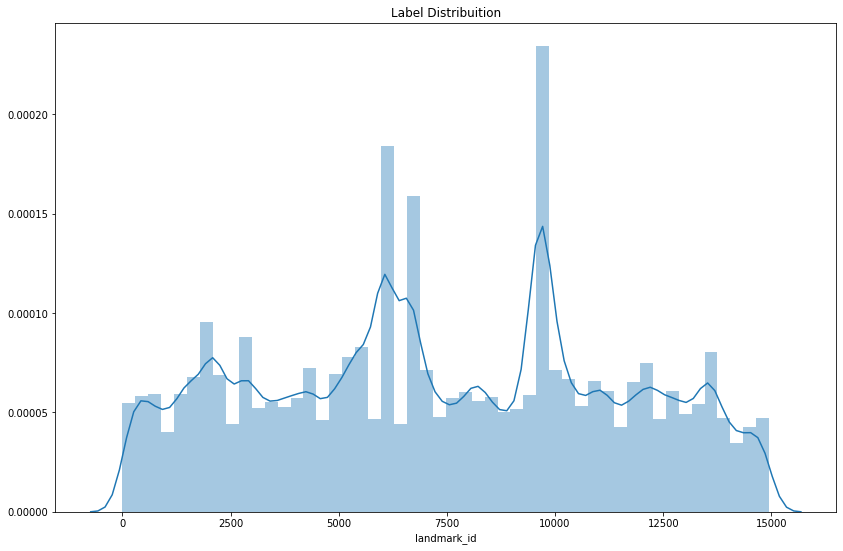

In [3]:
print("Data Shape", data.shape)

plt.figure(figsize = (14, 9))
plt.title('Label Distribuition')
sns.distplot(data['landmark_id'])

plt.show()

In [4]:
firsts = 50
most_frequent = pd.DataFrame(data.landmark_id.value_counts().head(firsts))
most_frequent.reset_index(inplace = True)
most_frequent.columns = ["landmark_id", "count"]
display(most_frequent.head(n = 20))

# print(most_frequent["landmark_id"].values)

,landmark_id,count
0,9633,50337
1,6051,50148
2,6599,23415
3,9779,18471
4,2061,13271
5,5554,11147
6,6651,9508
7,6696,9222
8,5376,9216
9,2743,8997


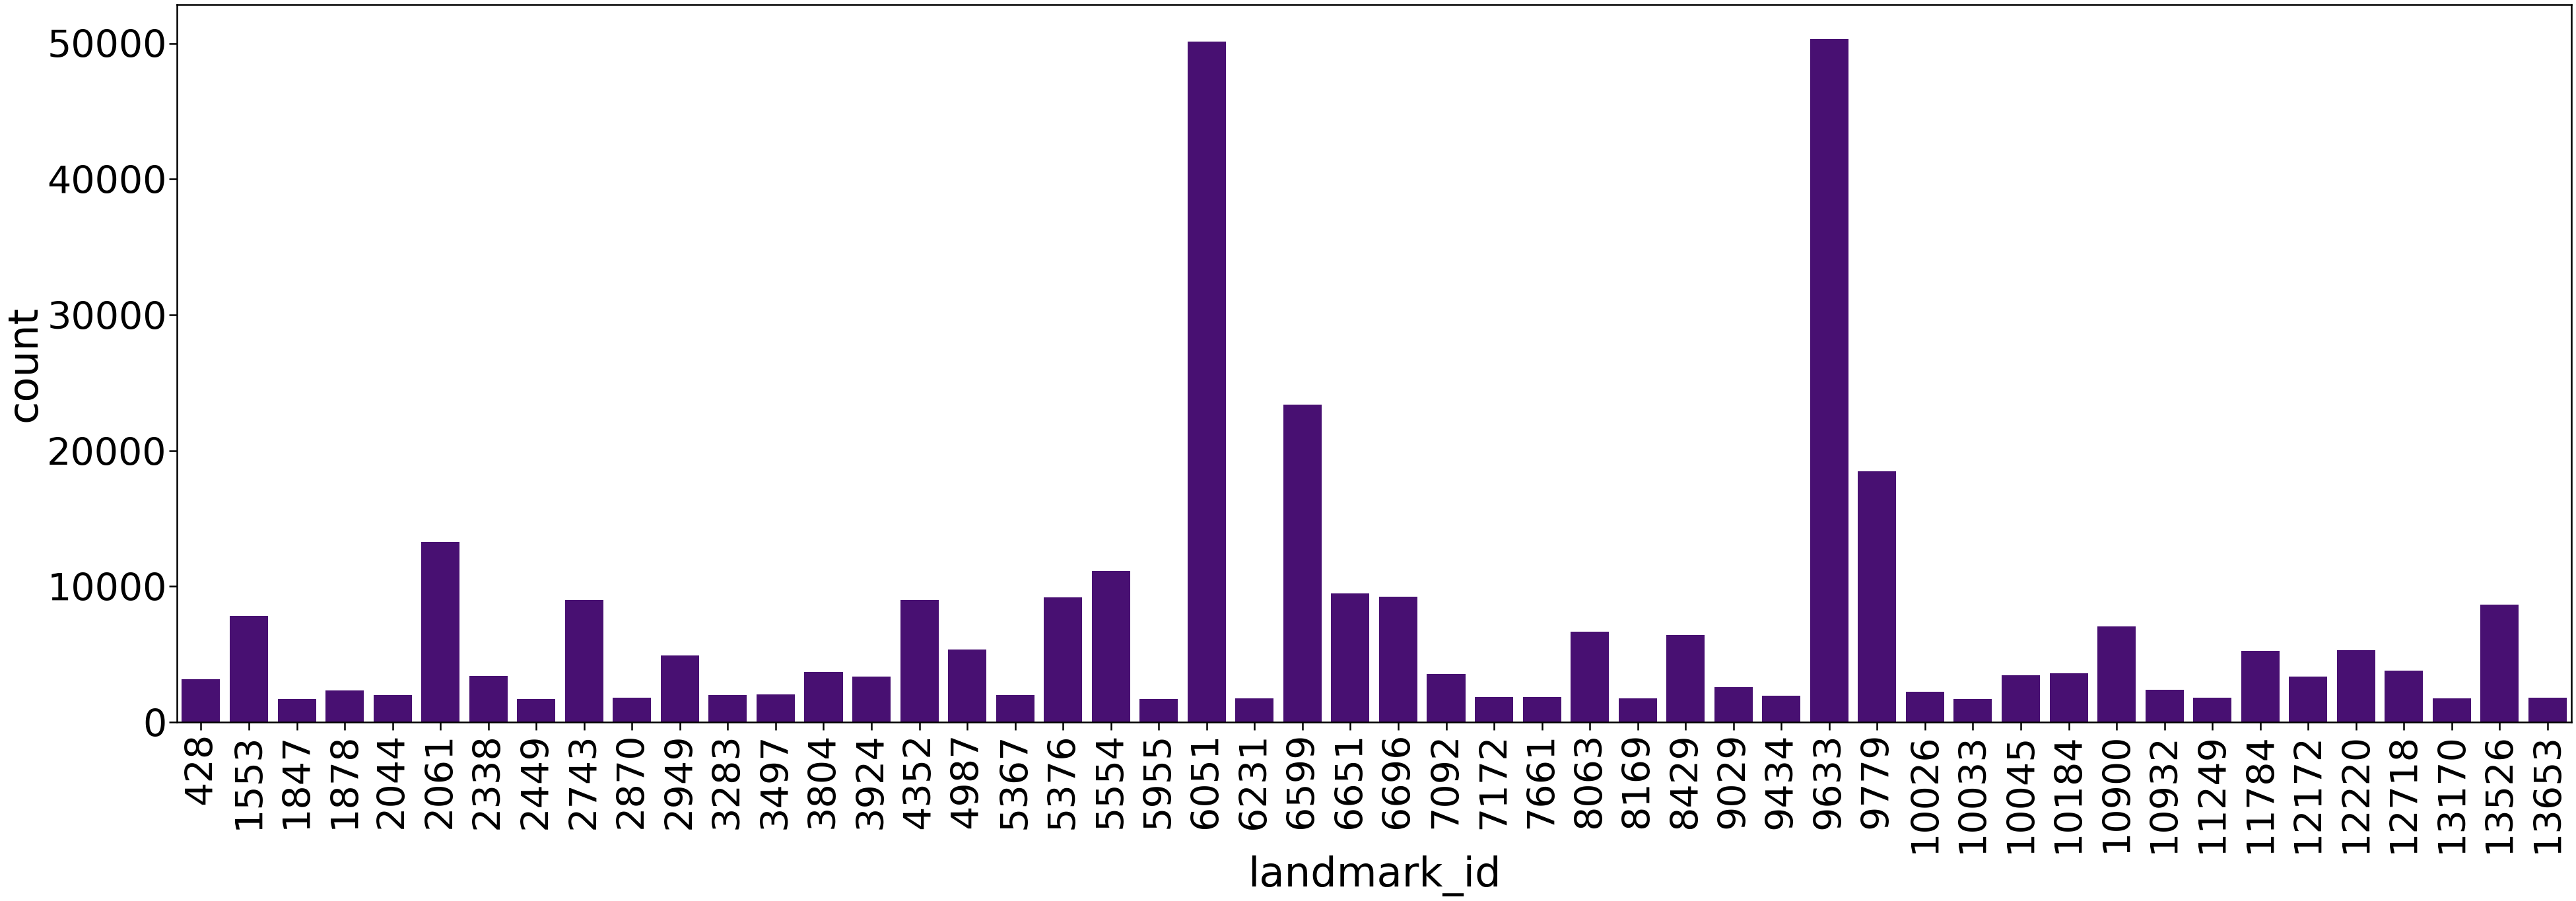

In [5]:
plt.figure(figsize = (65, 20))
sns.set_context("poster", font_scale=2.6)
sns.barplot(x = "landmark_id", y = "count", data = most_frequent, label = "Count", color = "indigo")

plt.xticks(rotation=90)
#plt.savefig('distribution.png')
plt.show()

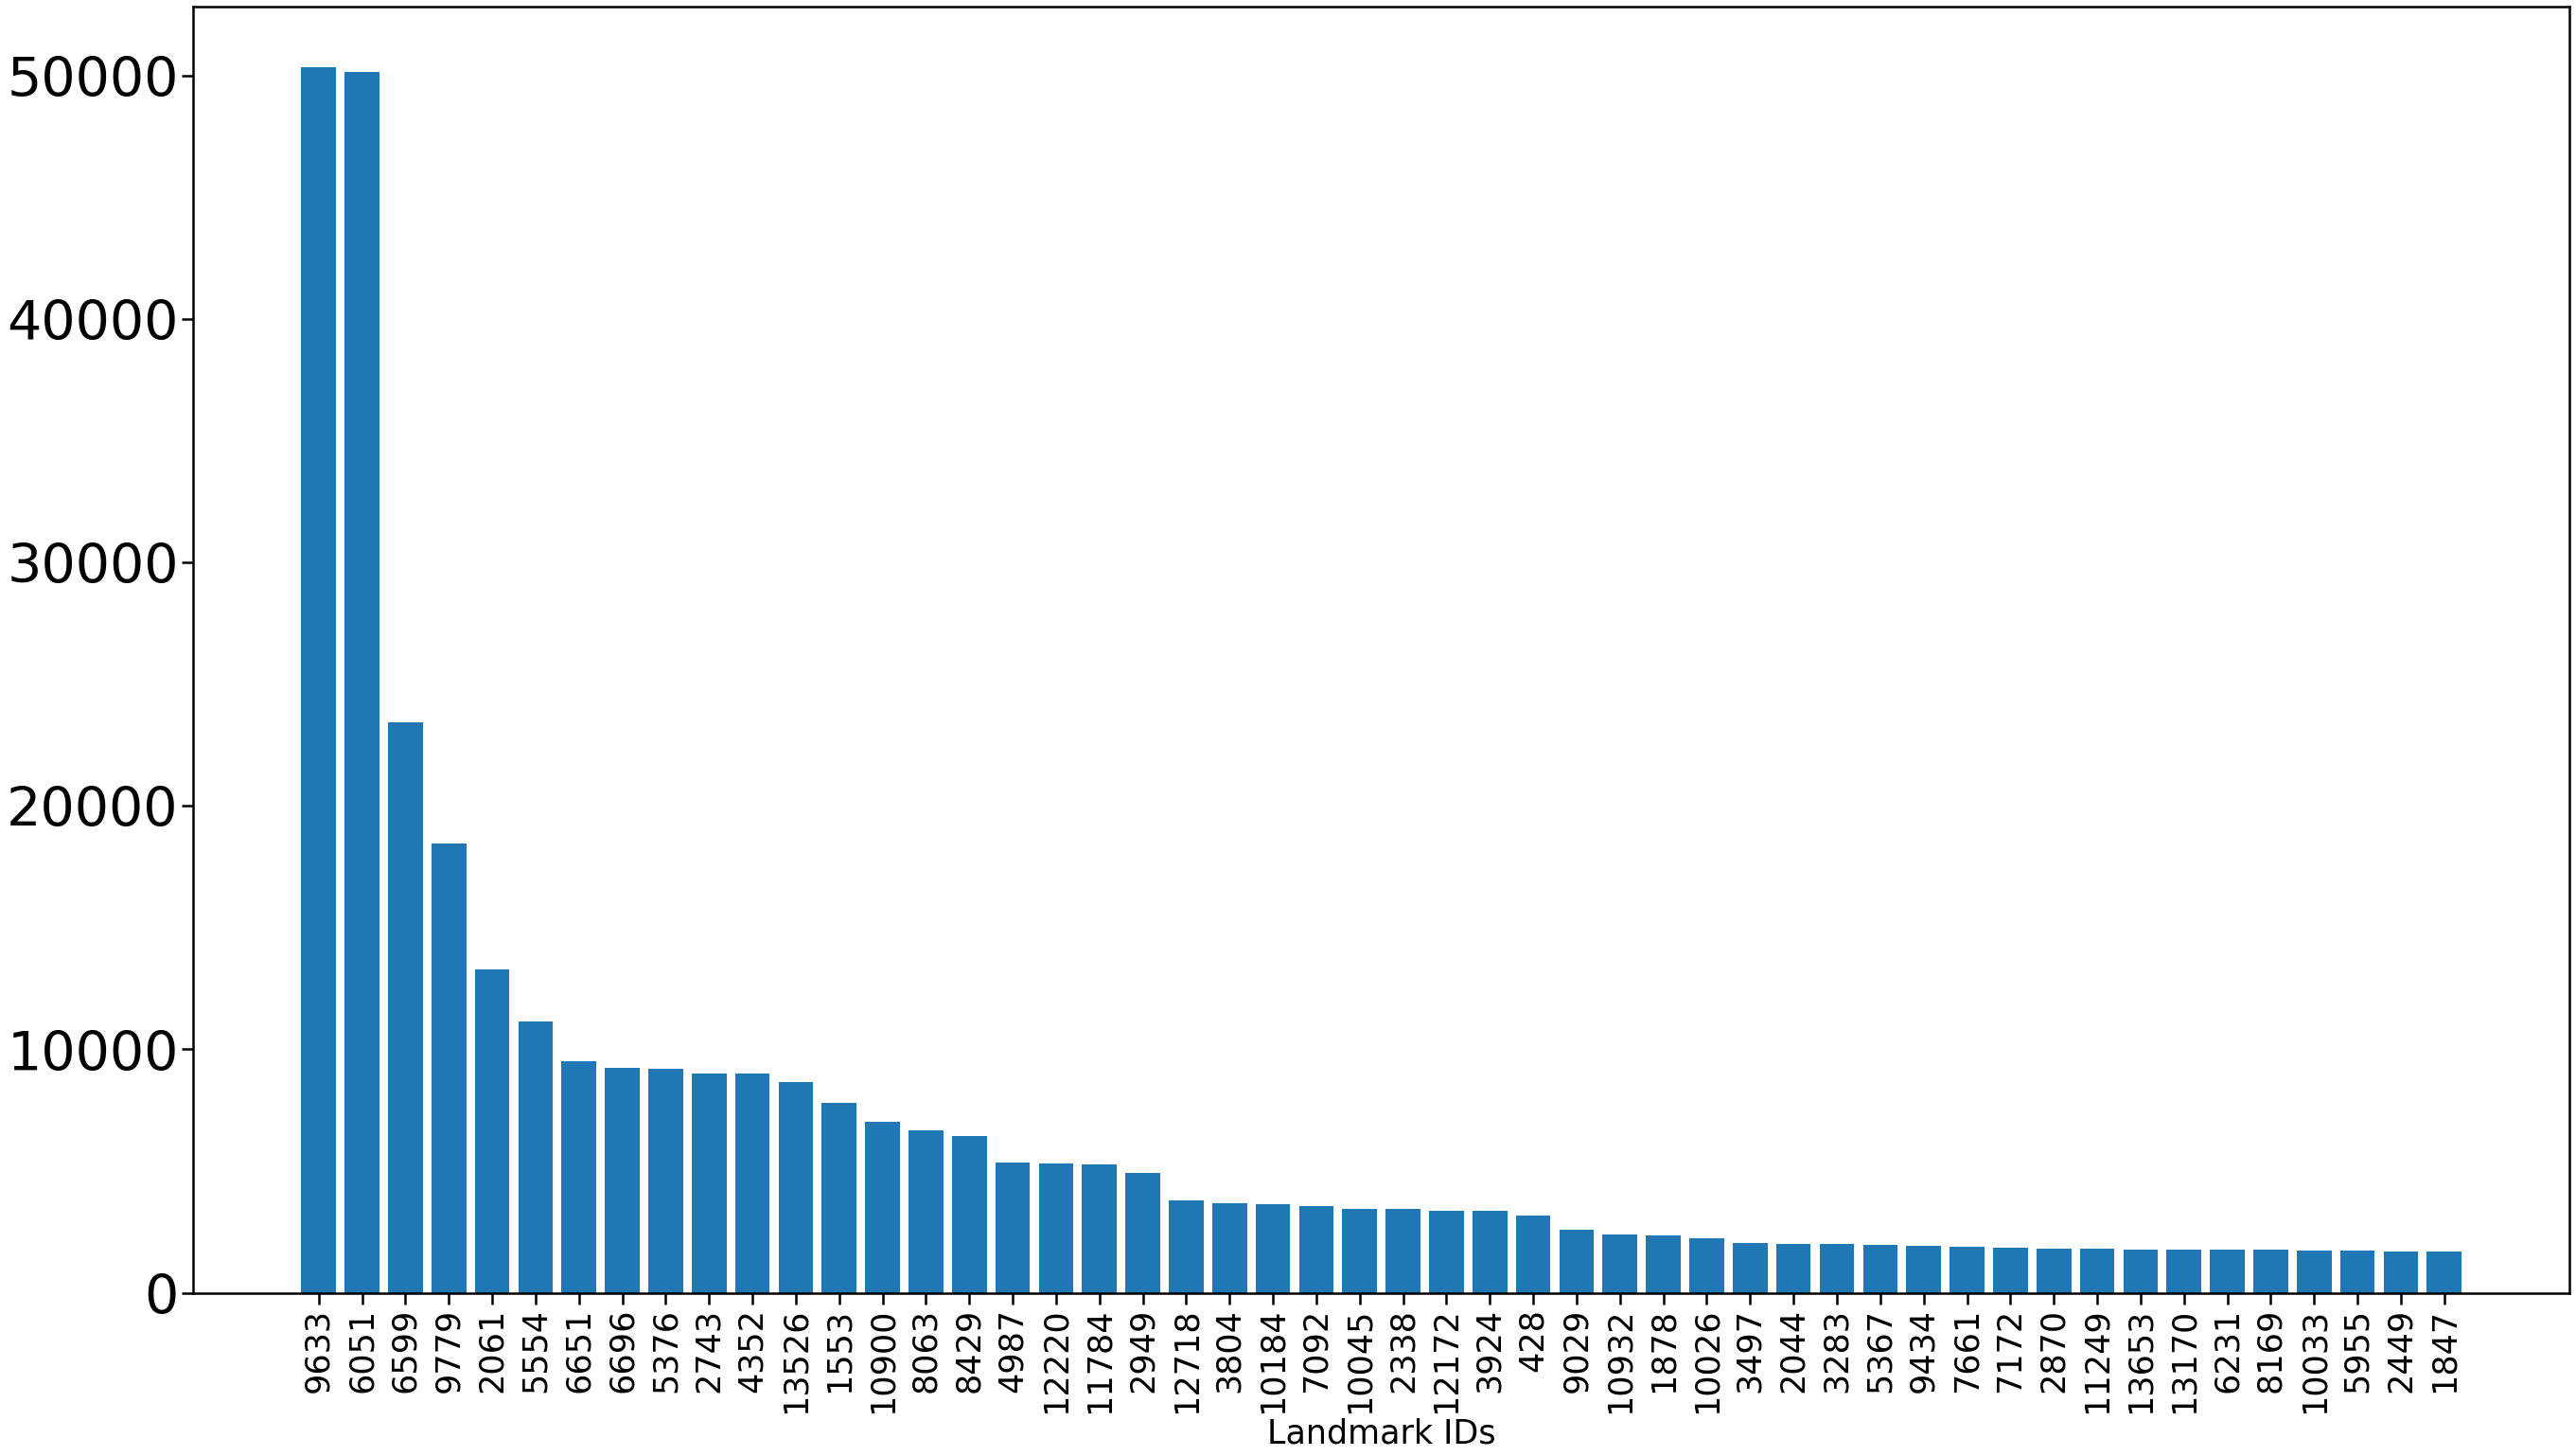

In [6]:
dict_id_count = {}
for index, row in most_frequent.iterrows():
    key = row['landmark_id']
    value = row['count']
    dict_id_count.update( {key : value} ) 
    
plt.figure(figsize = (45, 25))
plt.bar(range(len(dict_id_count)), list(dict_id_count.values()))
plt.xticks(range(len(dict_id_count)), list(dict_id_count.keys()), rotation = "vertical", fontsize = 35)
plt.xlabel("Landmark IDs", fontsize = 35)
plt.savefig('distribution_plt.png')
plt.show()

# print(dict_id_count)
    

In [7]:
last = 50
least_frequent = pd.DataFrame(data.landmark_id.value_counts().tail(last))
least_frequent.reset_index(inplace = True)
least_frequent.columns = ["landmark_id", "count"]
display(least_frequent.head(n = 20))

,landmark_id,count
0,6798,1
1,9936,1
2,5581,1
3,2395,1
4,5164,1
5,5617,1
6,4329,1
7,14189,1
8,6423,1
9,10143,1


In [8]:
labels = data["landmark_id"].values
print(np.sort(np.unique(labels)))

[    0     1     2 ... 14948 14949 14950]


In [9]:
path_to_resnet_10_results = "scores/10/NoLeak/resnet18_pretrained_no_augmentation_0.9885743856430054.pickle"
path_to_vgg_10_results = "scores/10/NoLeak/vgg16_pretrained_no_augmentation_0.9439451098442078.pickle"


path_to_resnet_20_results = "scores/20/resnet18_pretrained_no_augmentation_0.9834175109863281.pickle"
path_to_vgg_20_results = "scores/20/vgg16_pretrained_no_augmentation_0.9001208543777466.pickle"


path_to_resnet_30_results = "scores/30/resnet18_pretrained_no_augmentation_0.980502724647522.pickle"


path_to_resnet_50_results = "scores/50/resnet18_pretrained_no_augmentation_0.9754854440689087.pickle"


resnet_10_pickle_results = open(path_to_resnet_10_results, "rb")
resnet_10_results = pickle.load(resnet_10_pickle_results)

resnet_20_pickle_results = open(path_to_resnet_20_results, "rb")
resnet_20_results = pickle.load(resnet_20_pickle_results)

resnet_30_pickle_results = open(path_to_resnet_30_results, "rb")
resnet_30_results = pickle.load(resnet_30_pickle_results)

resnet_50_pickle_results = open(path_to_resnet_50_results, "rb")
resnet_50_results = pickle.load(resnet_50_pickle_results)

vgg_10_pickle_results = open(path_to_vgg_10_results, "rb")
vgg_10_results = pickle.load(vgg_10_pickle_results)

vgg_20_pickle_results = open(path_to_vgg_20_results, "rb")
vgg_20_results = pickle.load(vgg_20_pickle_results)

print("Dict Keys:", resnet_10_results.keys())

Dict Keys: dict_keys(['train_losses', 'train_accuracies', 'valid_losses', 'valid_accuracies', 'holdout_loss', 'holdout_accuracy'])


# Ploting Loss Function for Resnet18 and VGG16

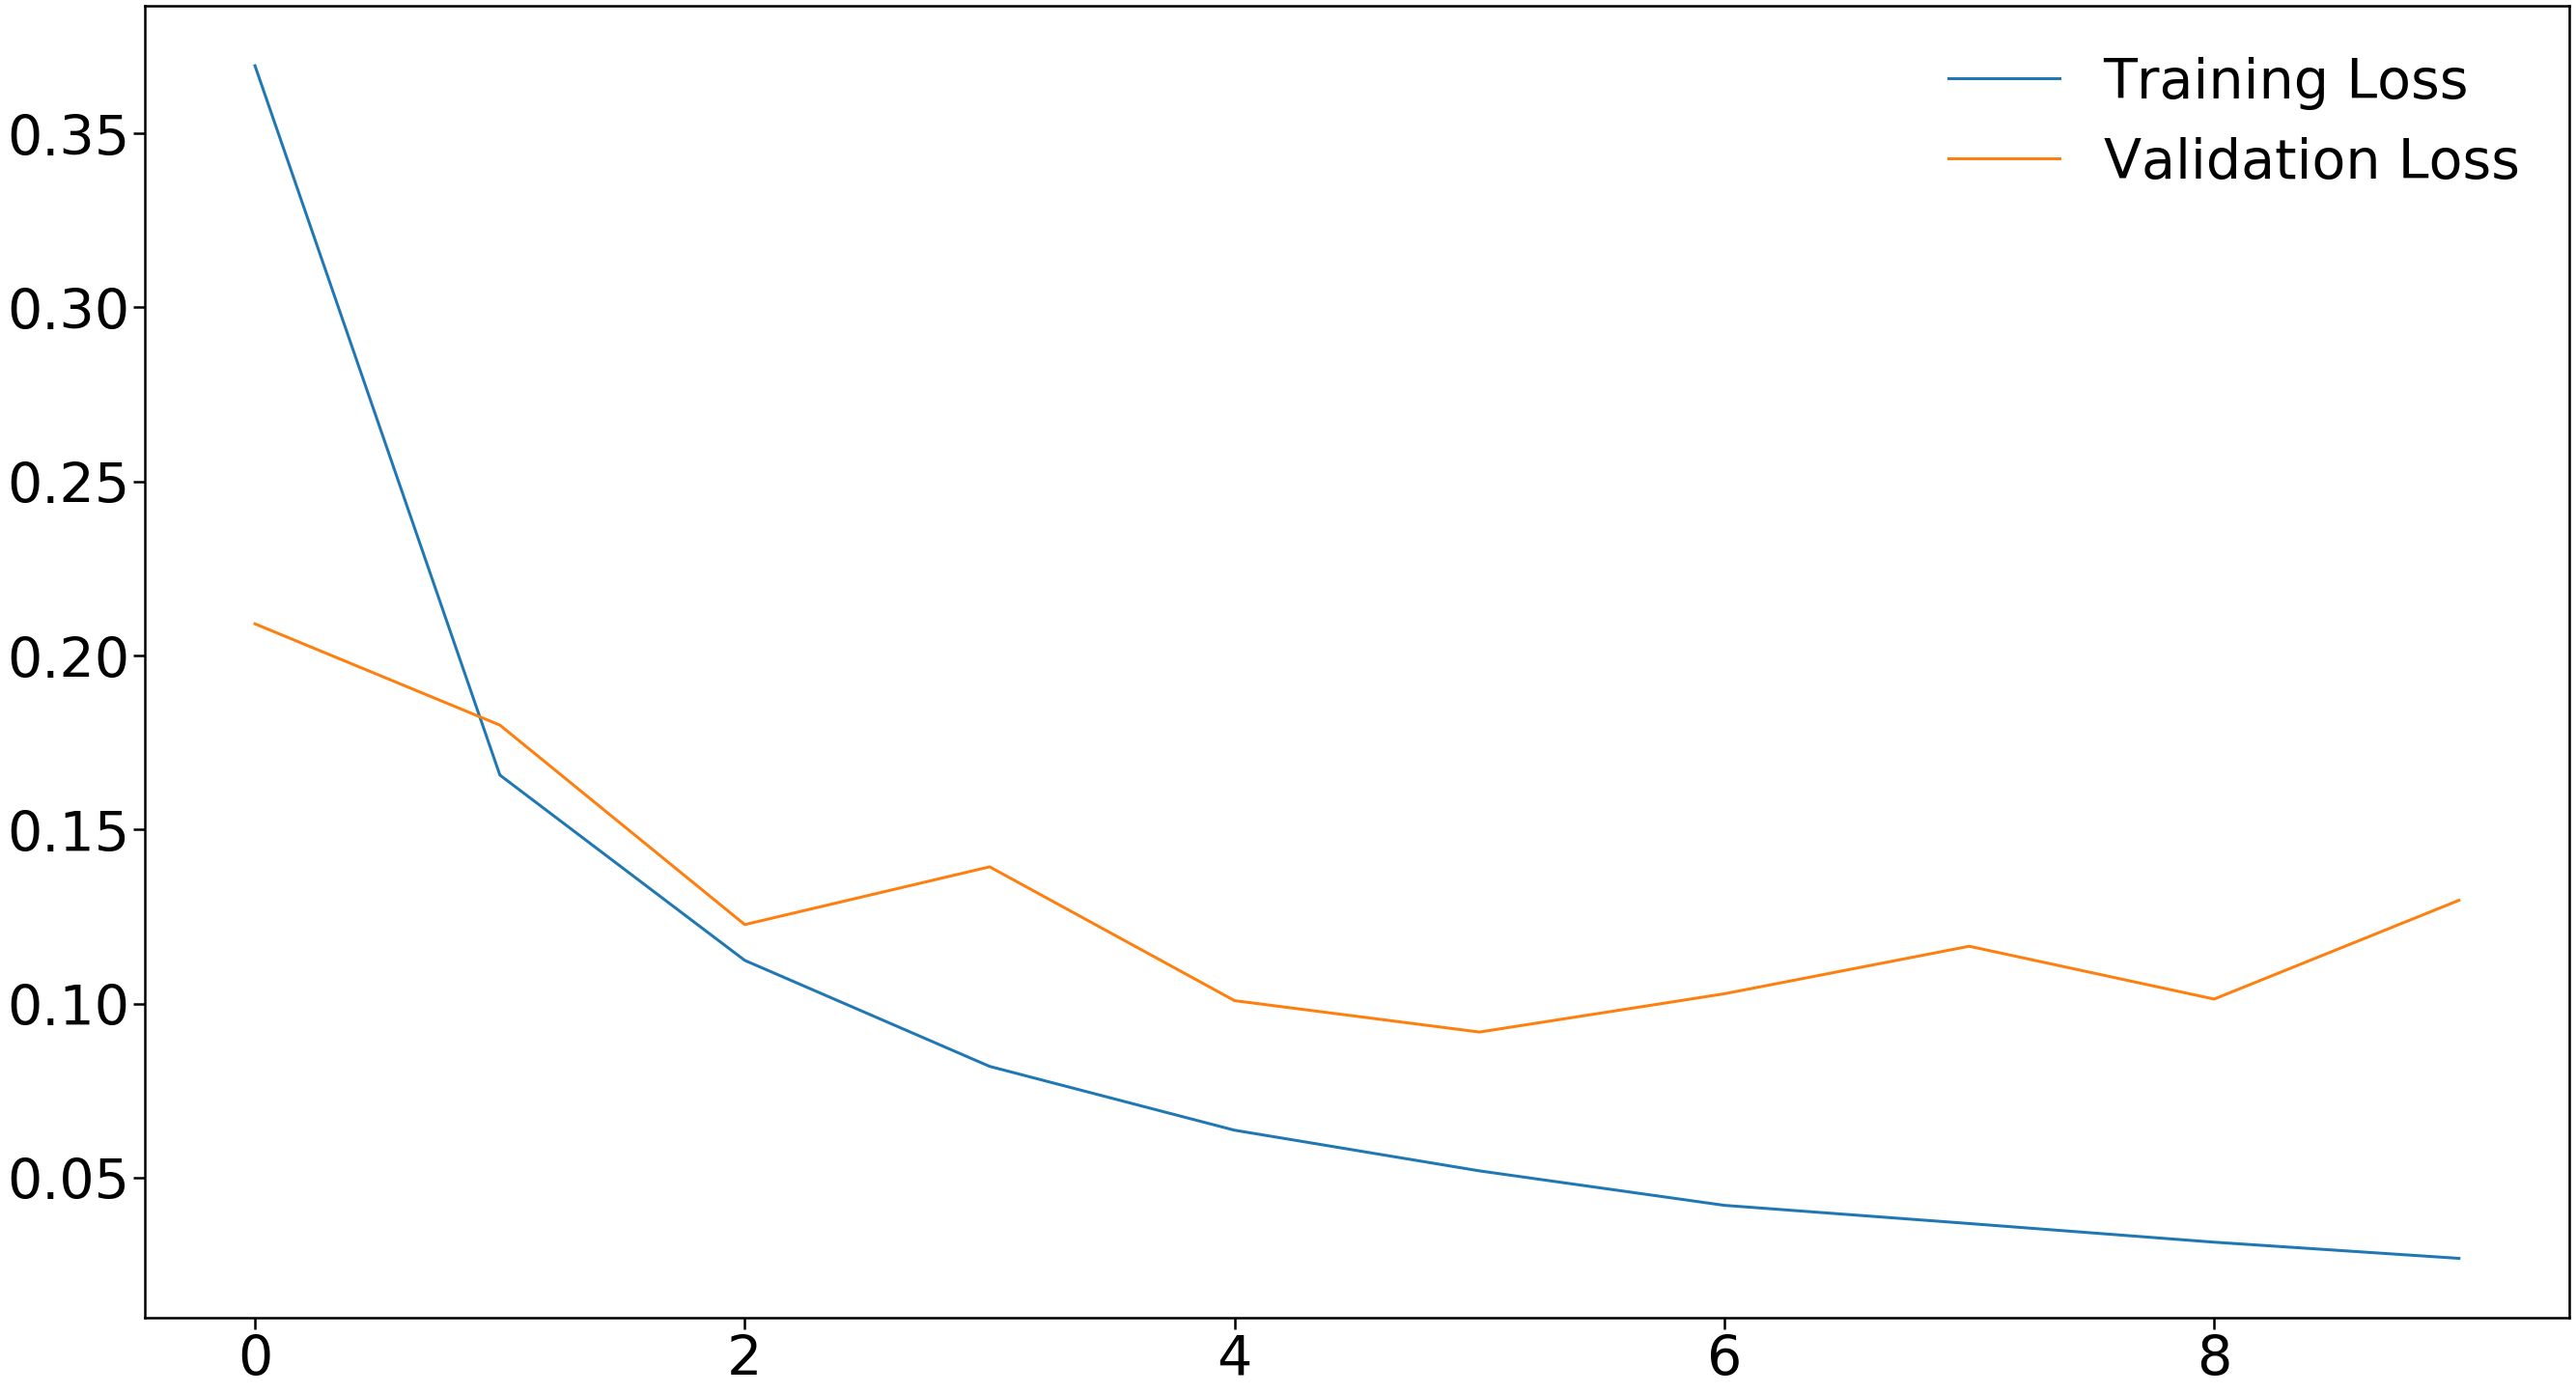

In [10]:
plt.figure(figsize = (45, 25))
plt.plot(resnet_50_results["train_losses"], label = "Training Loss")
plt.plot(resnet_50_results["valid_losses"], label = "Validation Loss")
plt.legend(frameon=False)
plt.show()

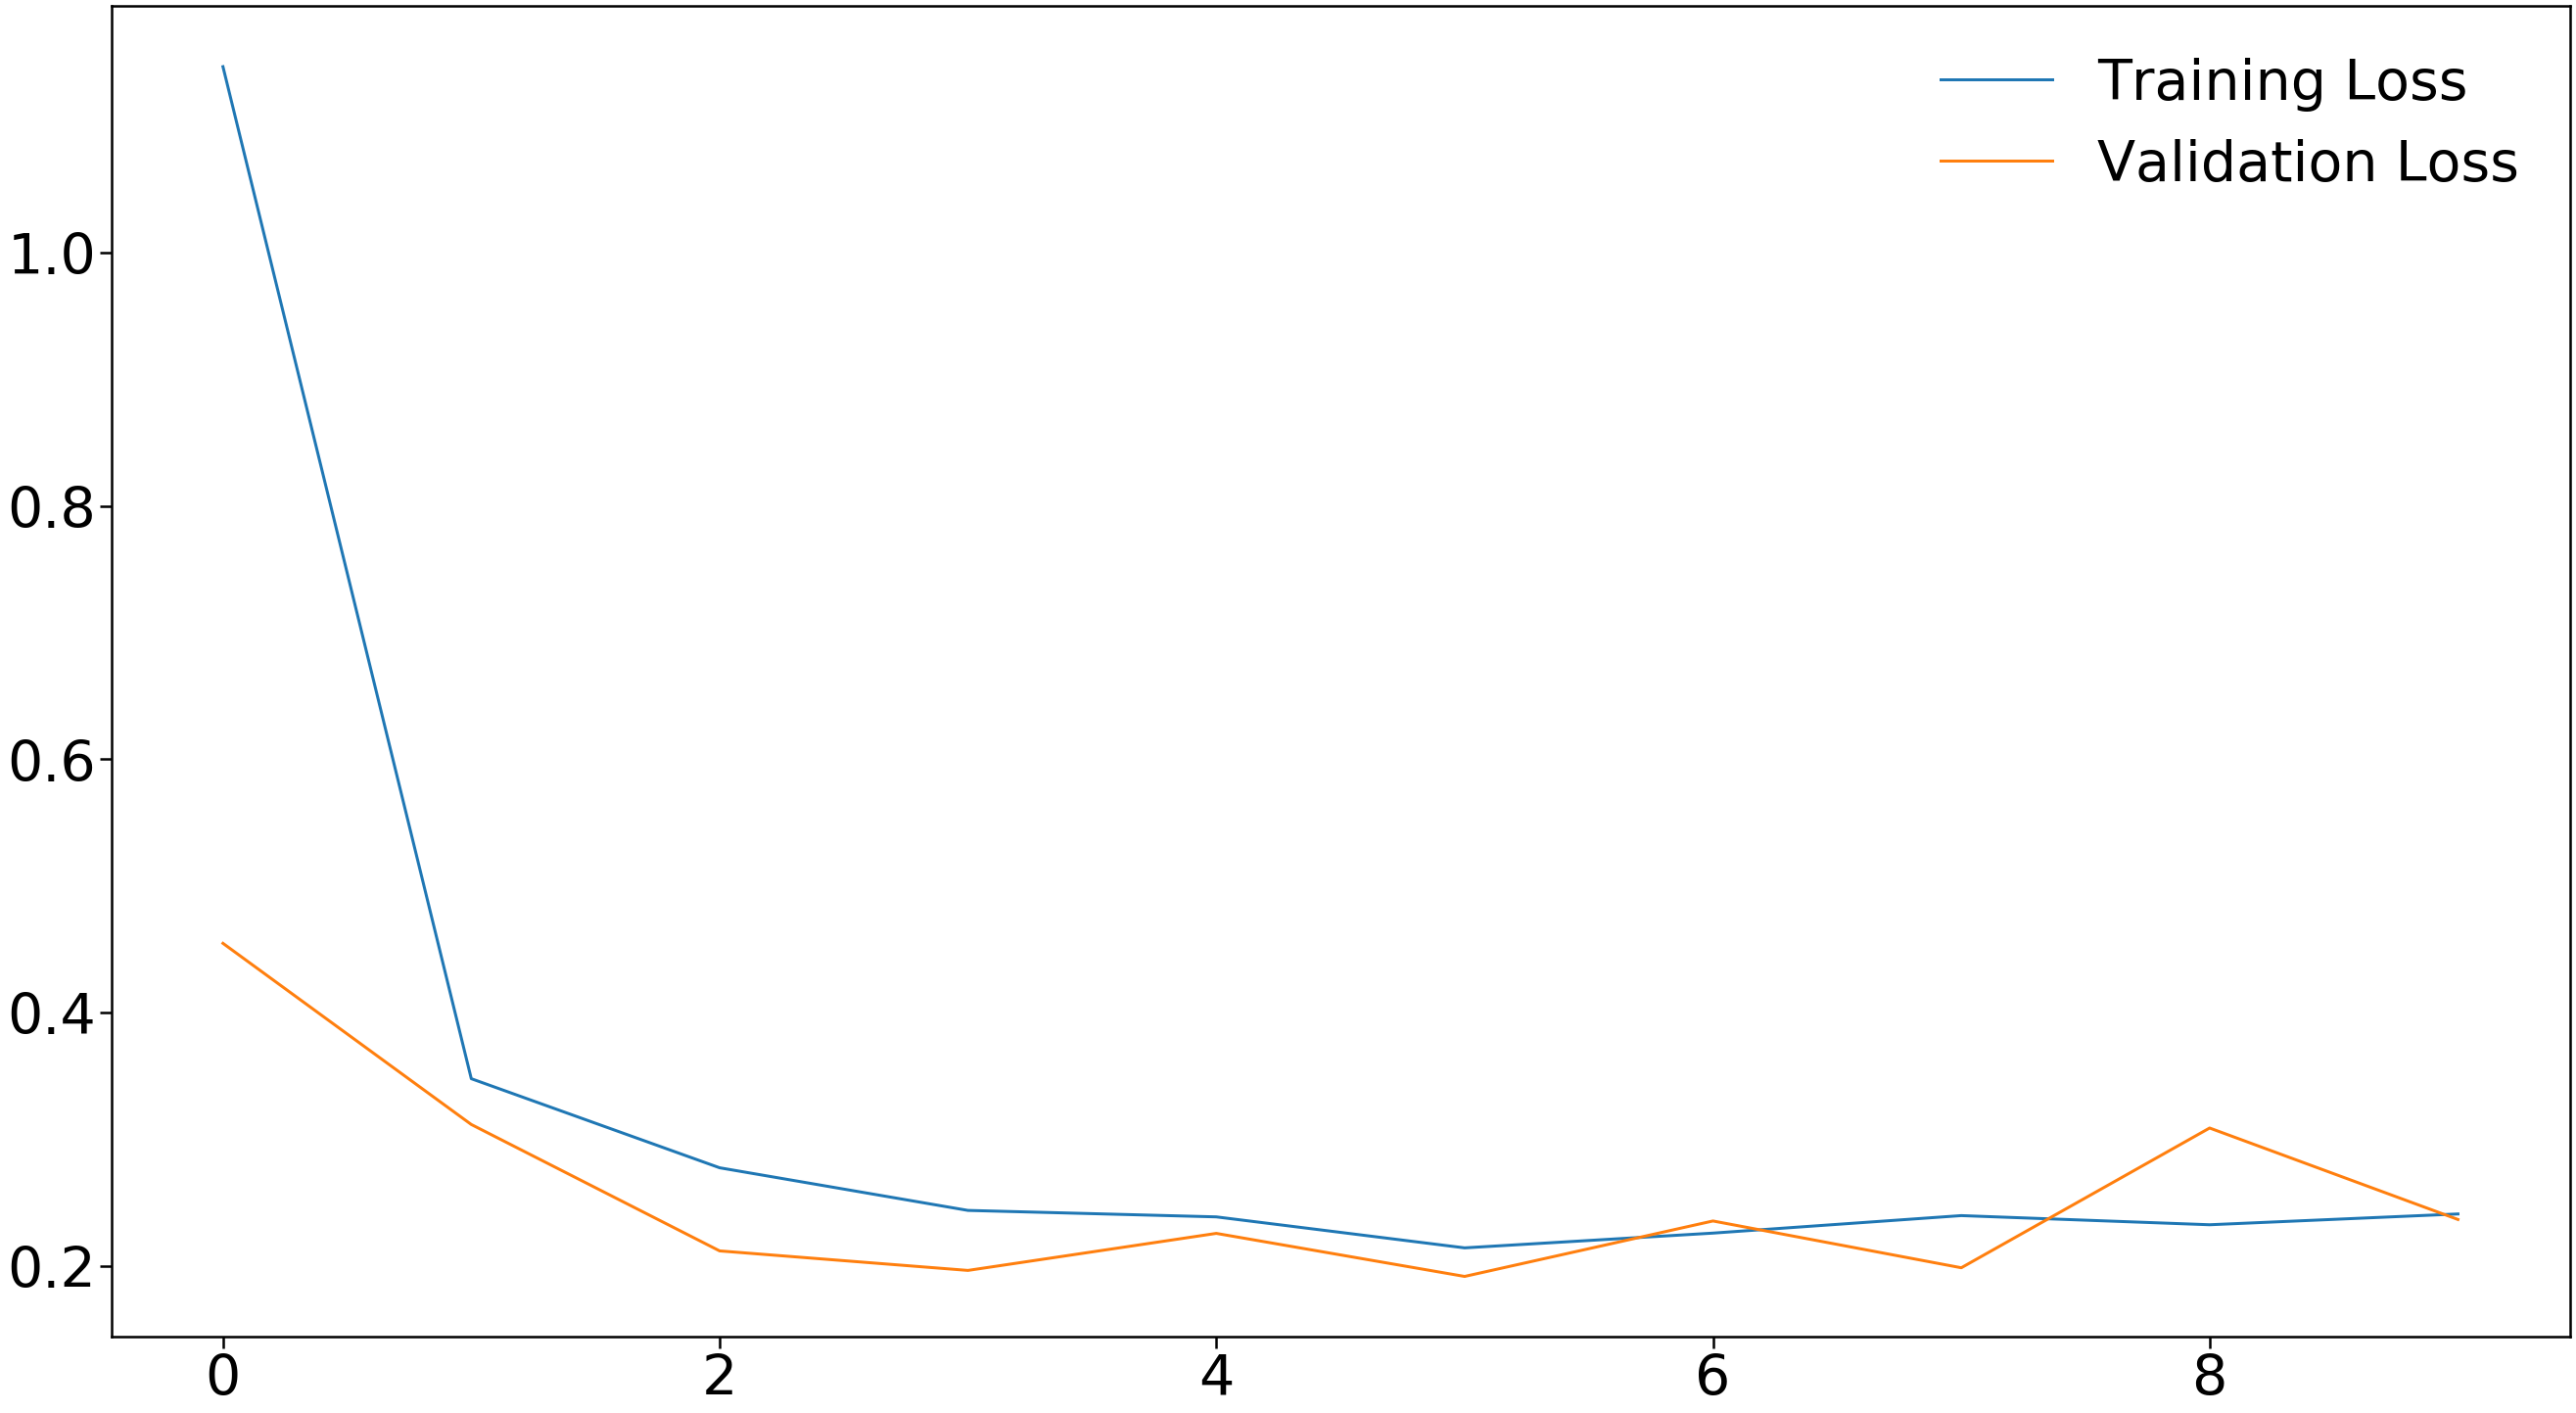

In [11]:
plt.figure(figsize = (45, 25))
plt.plot(vgg_10_results["train_losses"], label = "Training Loss")
plt.plot(vgg_10_results["valid_losses"], label = "Validation Loss")
plt.legend(frameon=False)
plt.show()

# Plotting Accuracy Scores for Resnet18 and VGG16  

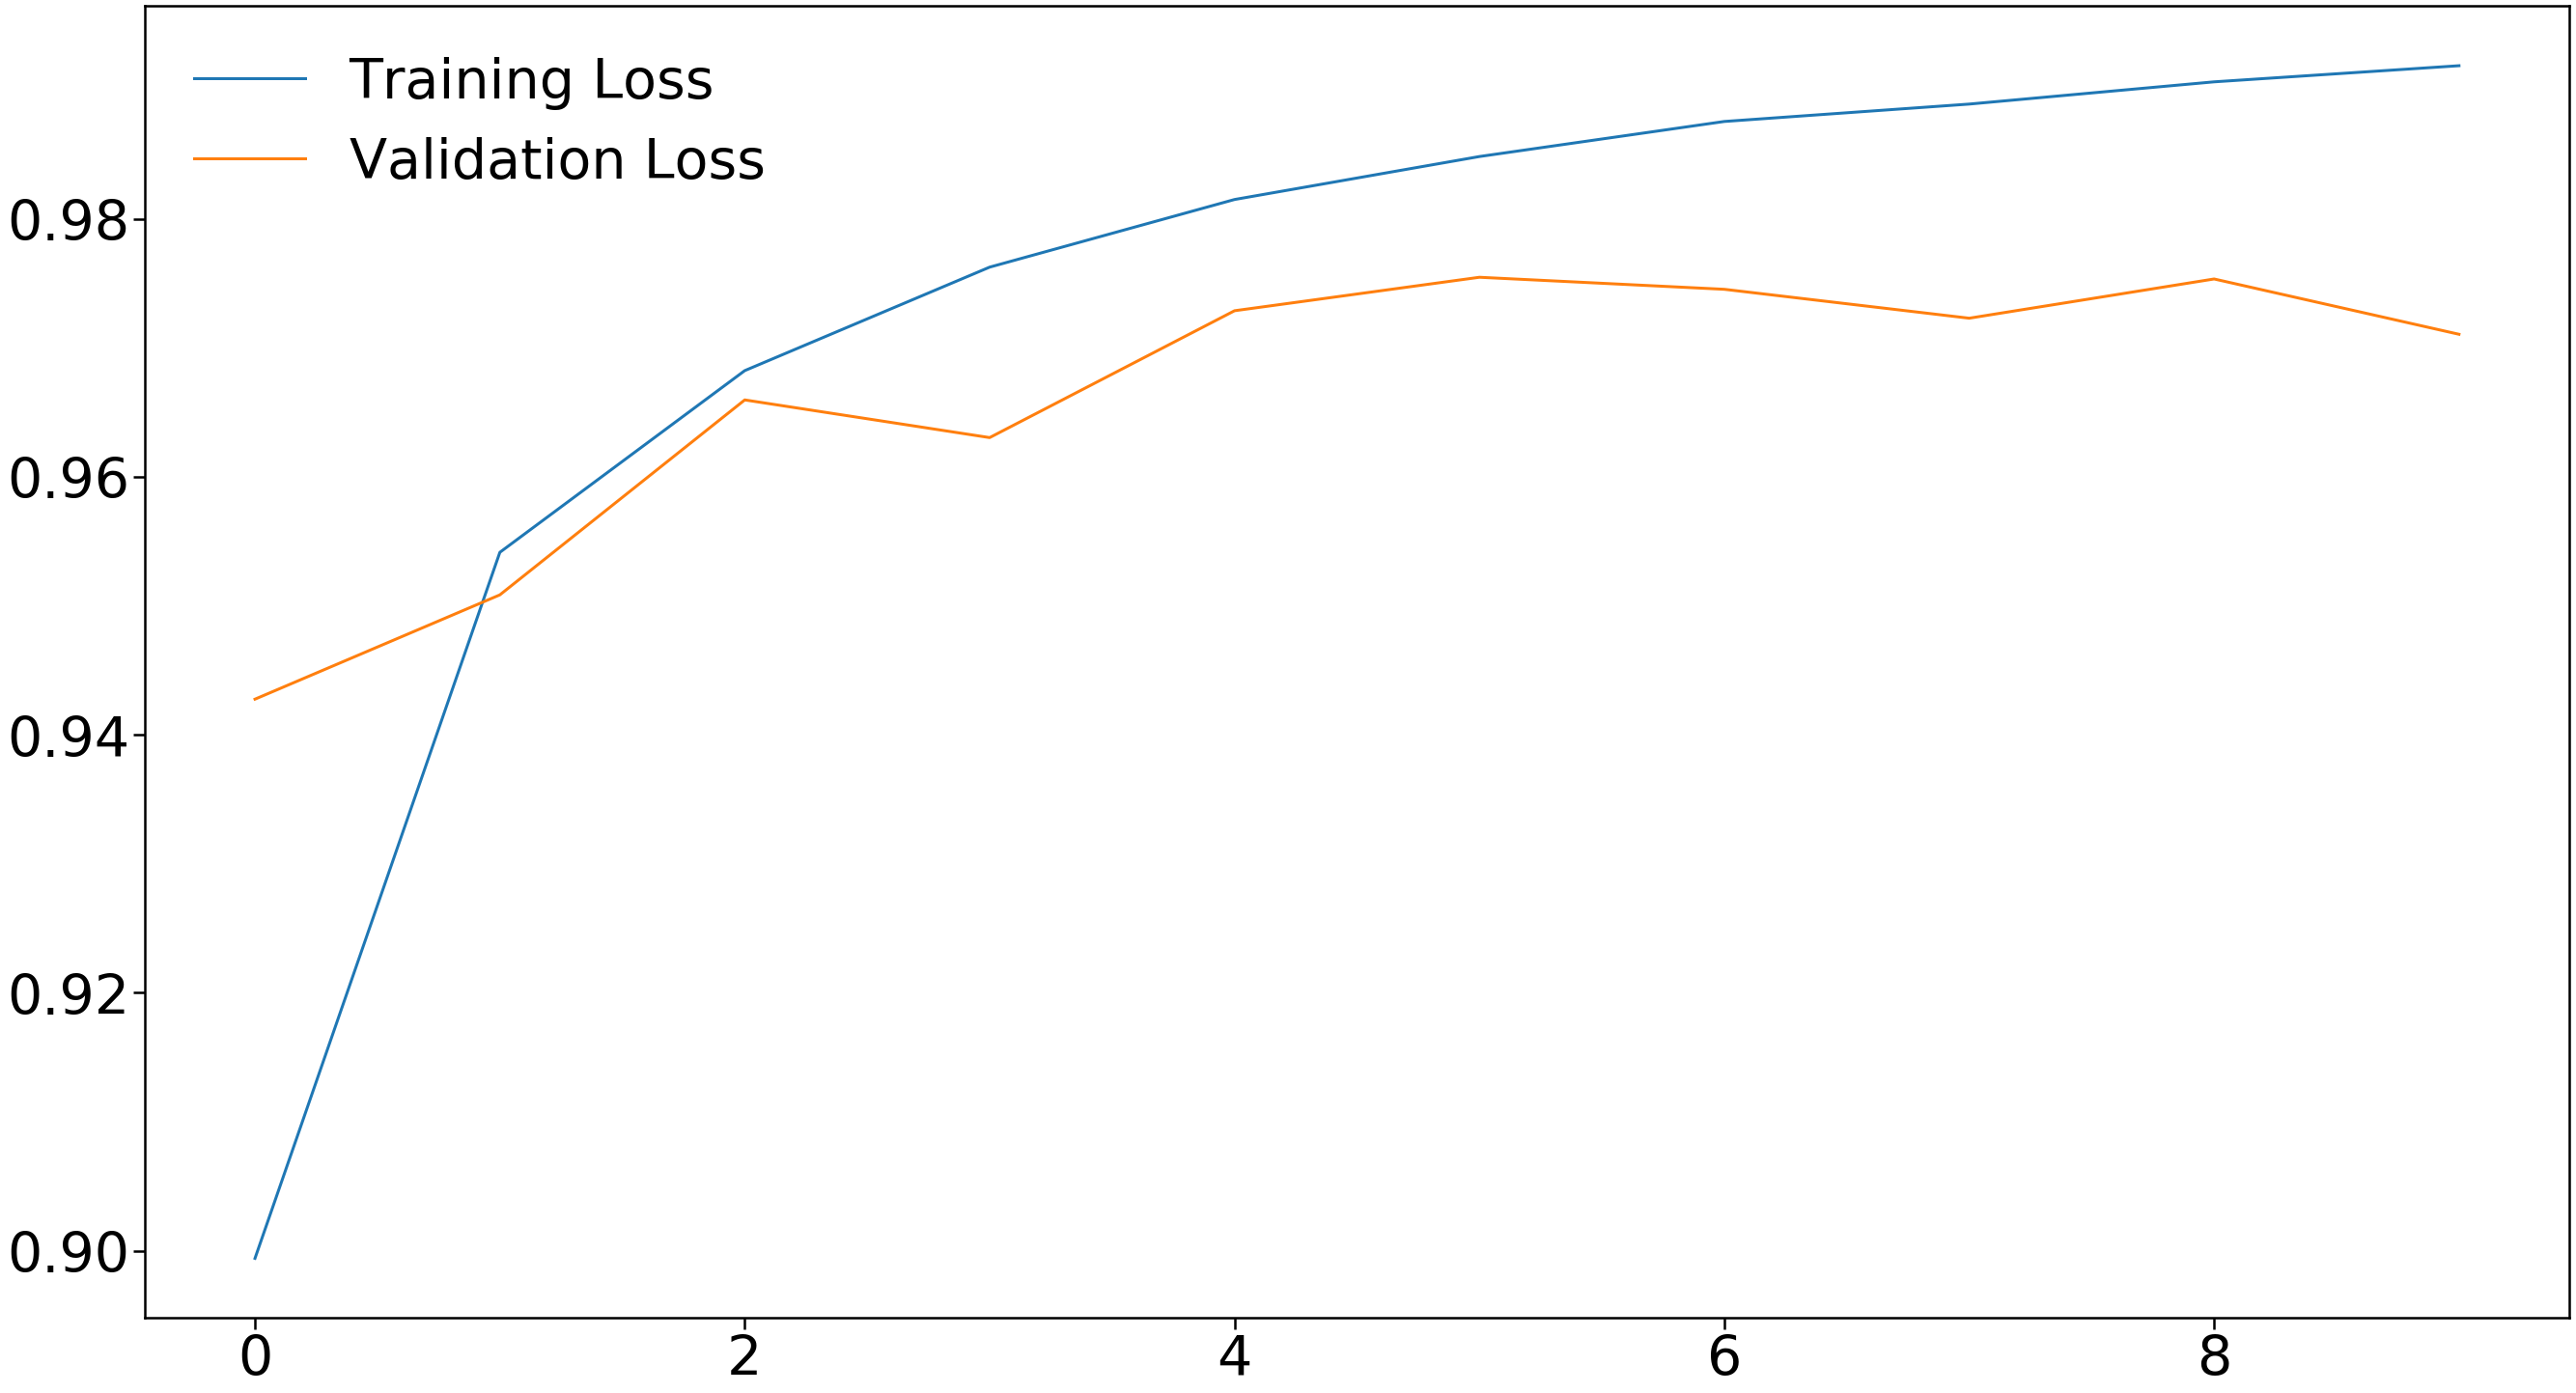

In [12]:
plt.figure(figsize = (45, 25))
plt.plot(resnet_50_results["train_accuracies"], label = "Training Loss")
plt.plot(resnet_50_results["valid_accuracies"], label = "Validation Loss")
plt.legend(frameon=False)
plt.show()

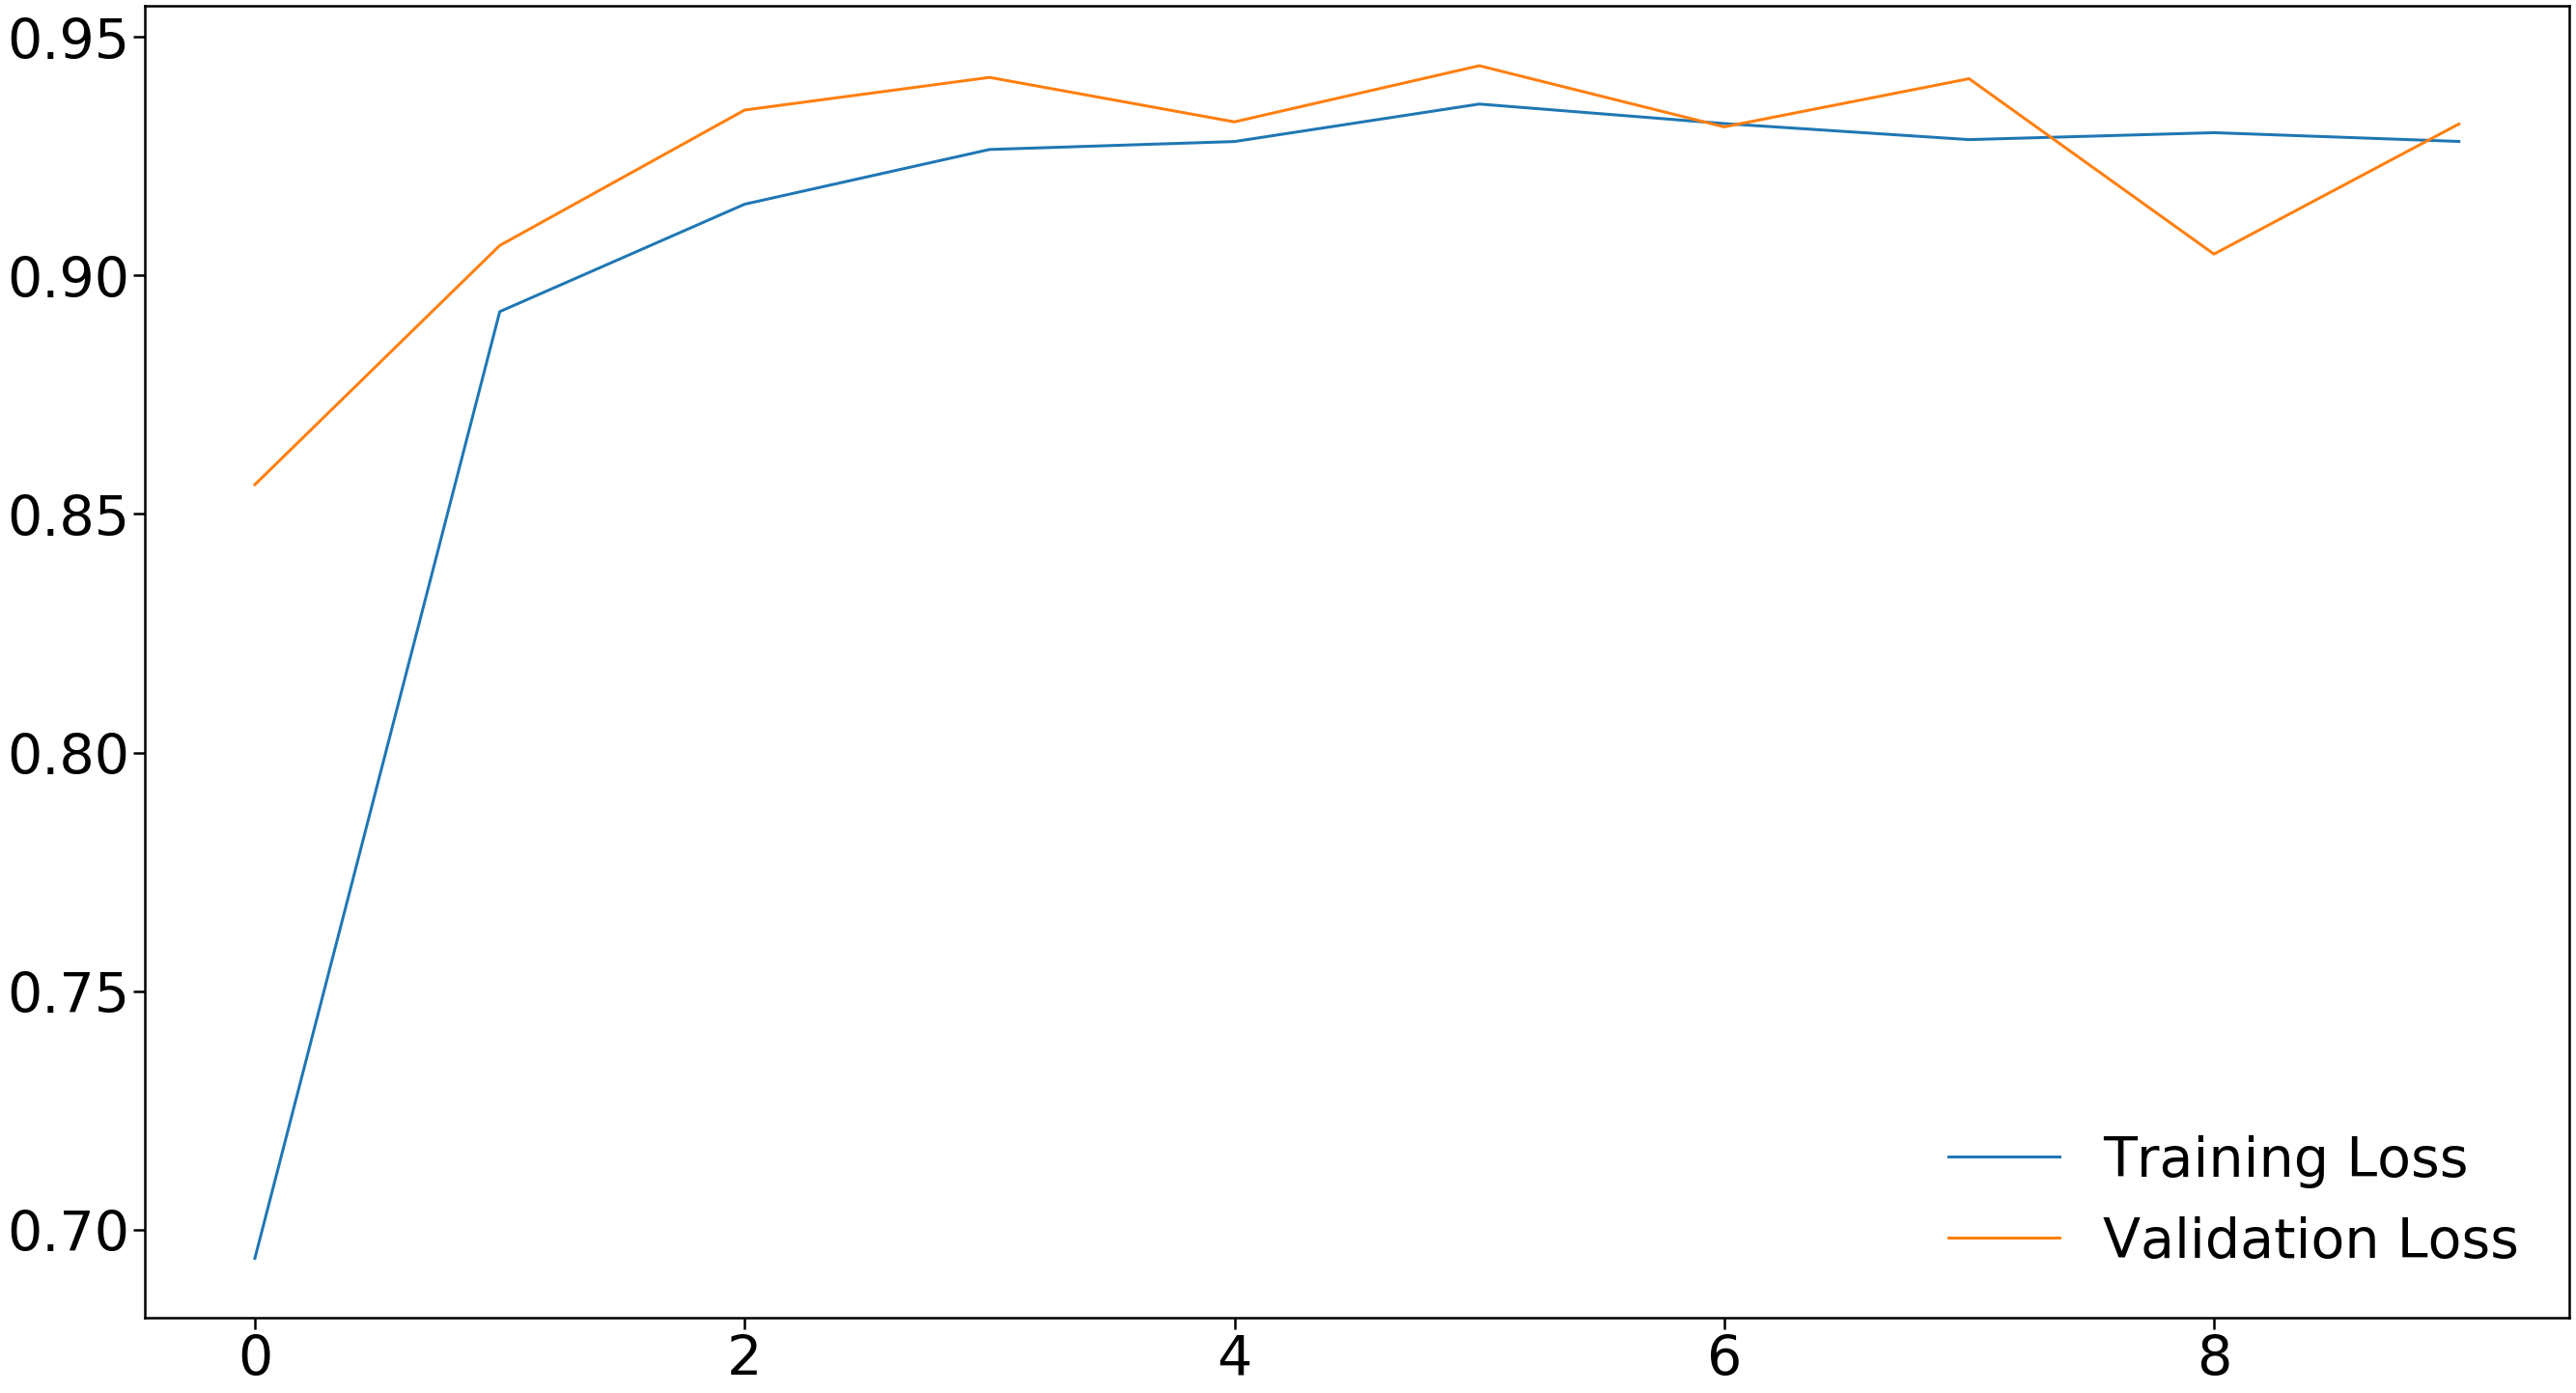

In [13]:
plt.figure(figsize = (45, 25))
plt.plot(vgg_10_results["train_accuracies"], label = "Training Loss")
plt.plot(vgg_10_results["valid_accuracies"], label = "Validation Loss")
plt.legend(frameon=False)
plt.show()

In [14]:
import numpy as np
idx = np.argmax(resnet_50_results["valid_accuracies"])

print(resnet_50_results["train_accuracies"][idx])
print(resnet_50_results["valid_accuracies"][idx])
print(resnet_50_results["holdout_accuracy"])

0.9848484163588215
0.9754854294649217
0.9681546892438616


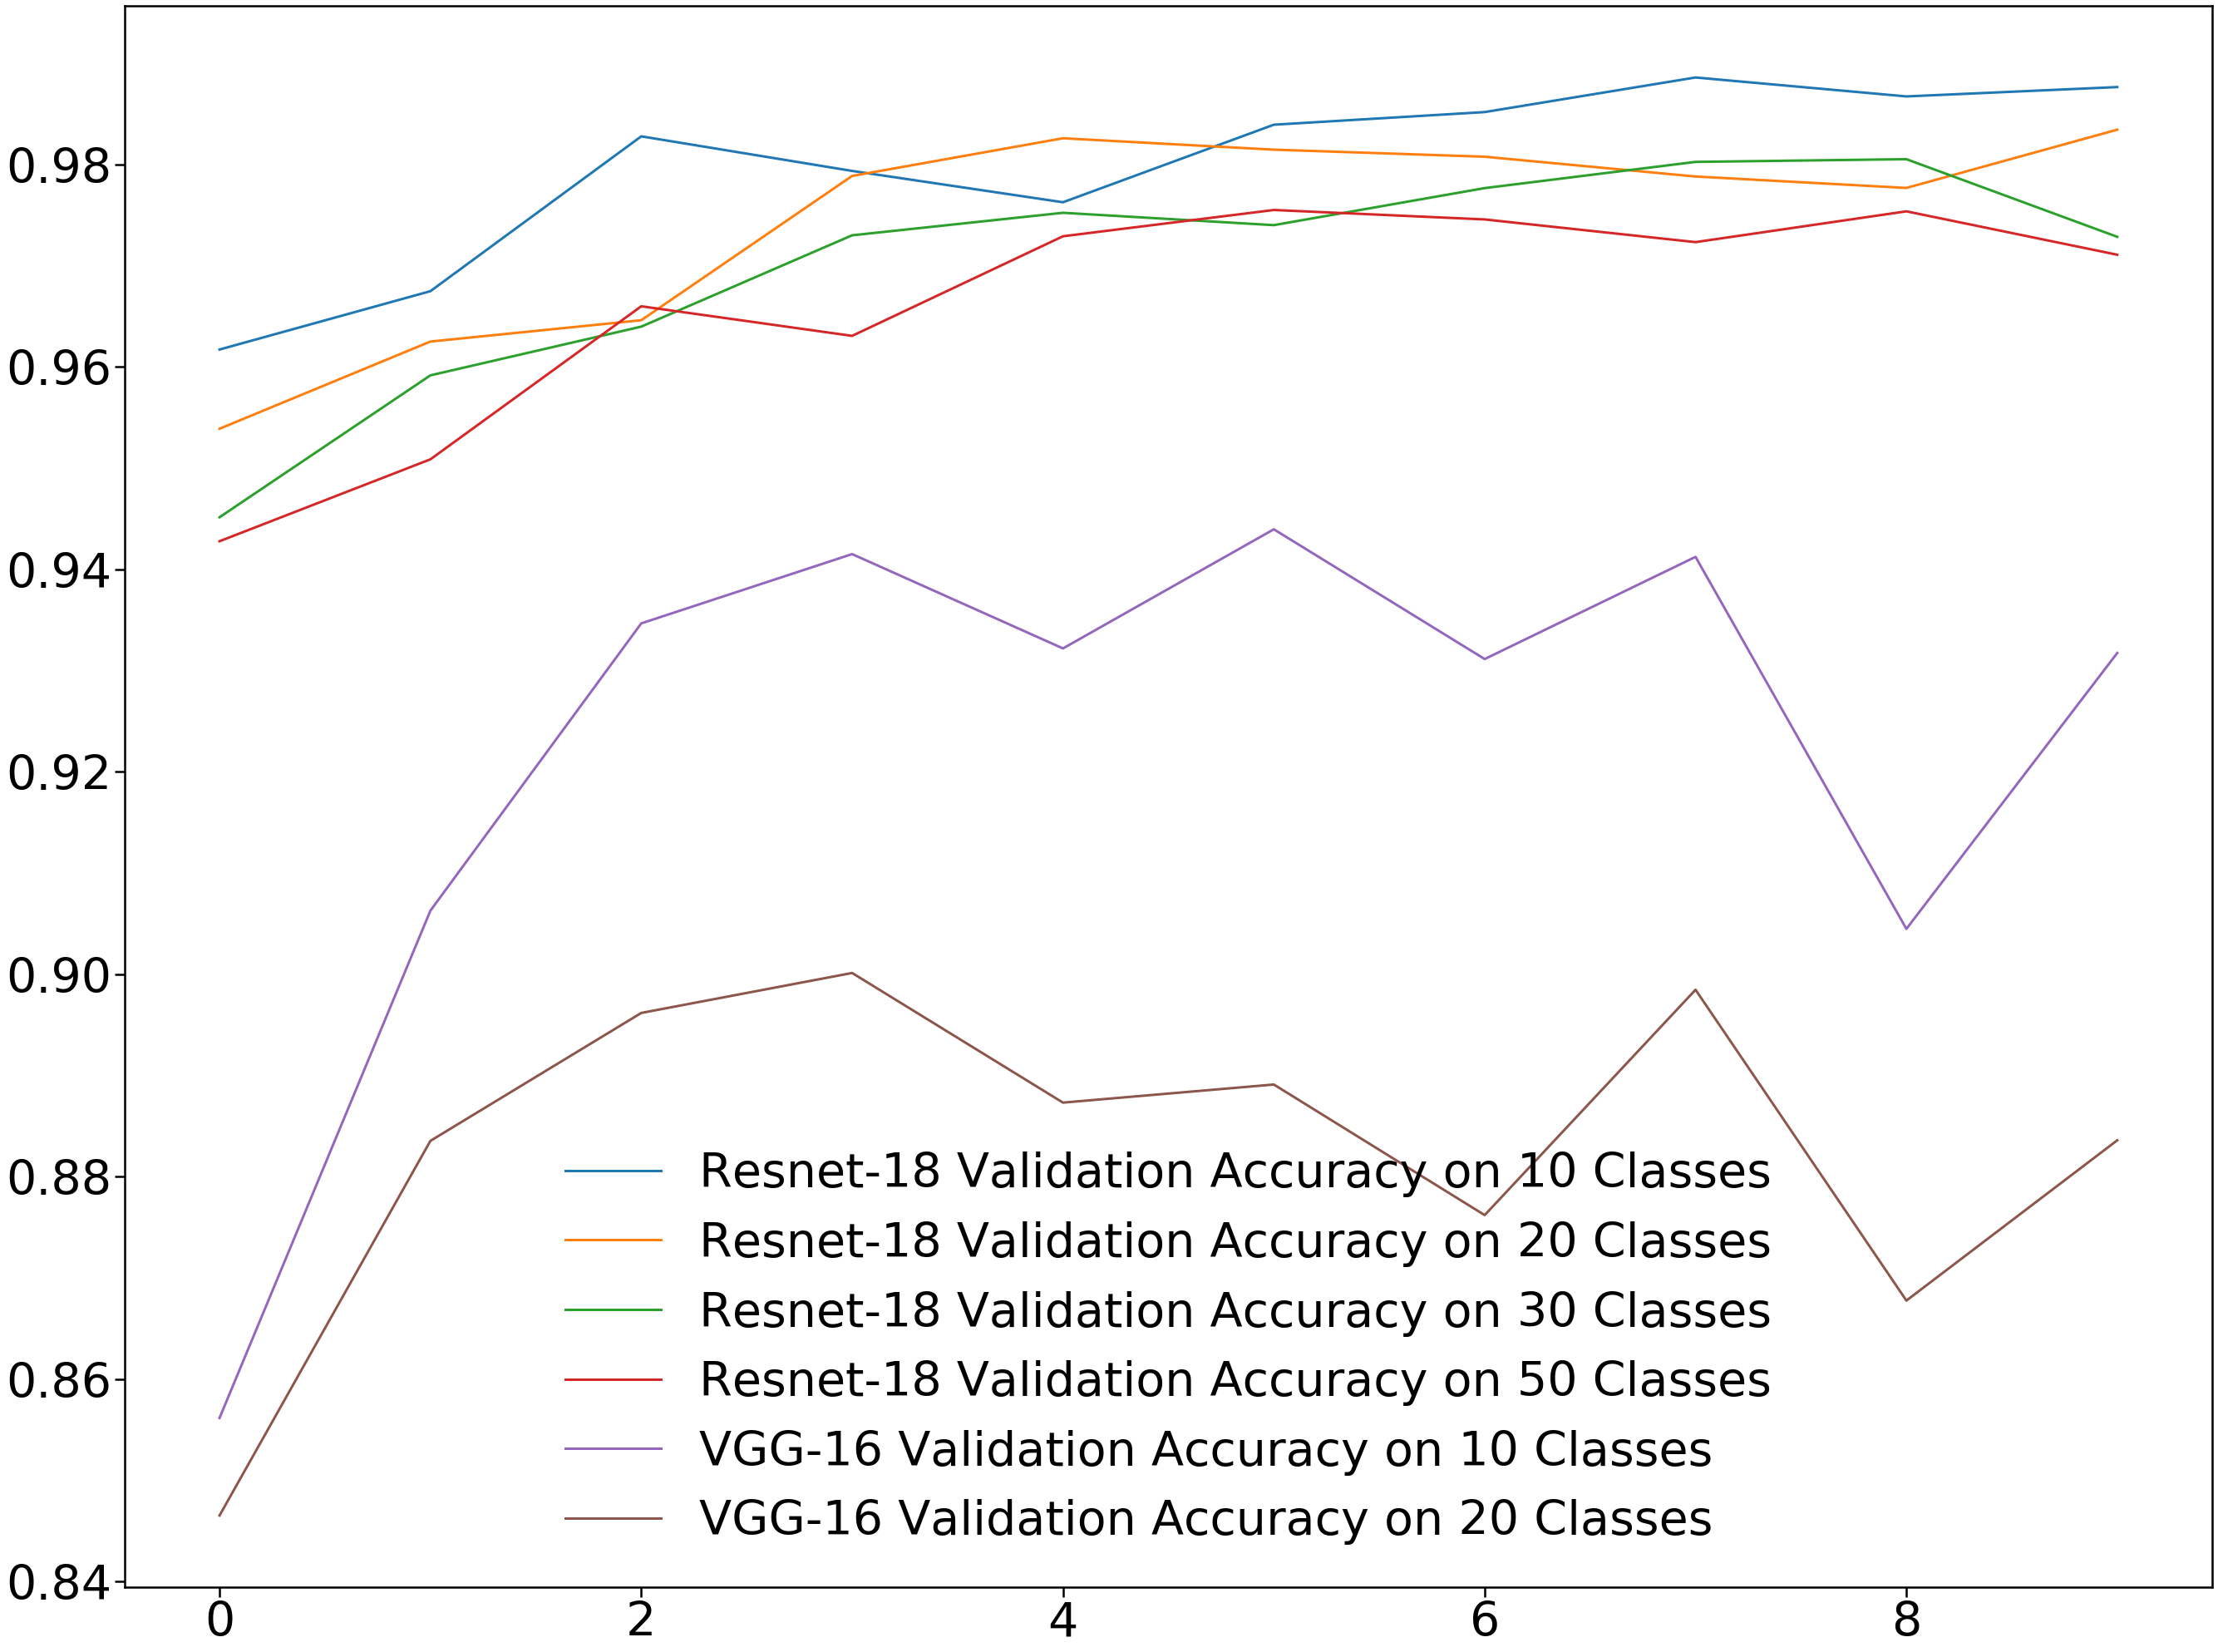

In [15]:
# plt.plot(resnet_10_results["train_accuracies"], label = "Resnet-18 Train Accuracy on 10 Classes")
# plt.plot(resnet_20_results["train_accuracies"], label = "Resnet-18 Train Accuracy on 20 Classes")
# plt.plot(resnet_30_results["train_accuracies"], label = "Resnet-18 Train Accuracy on 30 Classes")

# plt.plot(vgg_10_results["train_accuracies"], label = "VGG-16 Train Accuracy on 10 Classes")
# plt.plot(vgg_20_results["train_accuracies"], label = "VGG-16 Train Accuracy on 20 Classes")

plt.figure(figsize = (45, 35))
plt.plot(resnet_10_results["valid_accuracies"], label = "Resnet-18 Validation Accuracy on 10 Classes")
plt.plot(resnet_20_results["valid_accuracies"], label = "Resnet-18 Validation Accuracy on 20 Classes")
plt.plot(resnet_30_results["valid_accuracies"], label = "Resnet-18 Validation Accuracy on 30 Classes")
plt.plot(resnet_50_results["valid_accuracies"], label = "Resnet-18 Validation Accuracy on 50 Classes")

plt.plot(vgg_10_results["valid_accuracies"], label = "VGG-16 Validation Accuracy on 10 Classes")
plt.plot(vgg_20_results["valid_accuracies"], label = "VGG-16 Validation Accuracy on 20 Classes")

plt.legend(frameon=False)
plt.savefig('validation_accuracy.png')
plt.show()

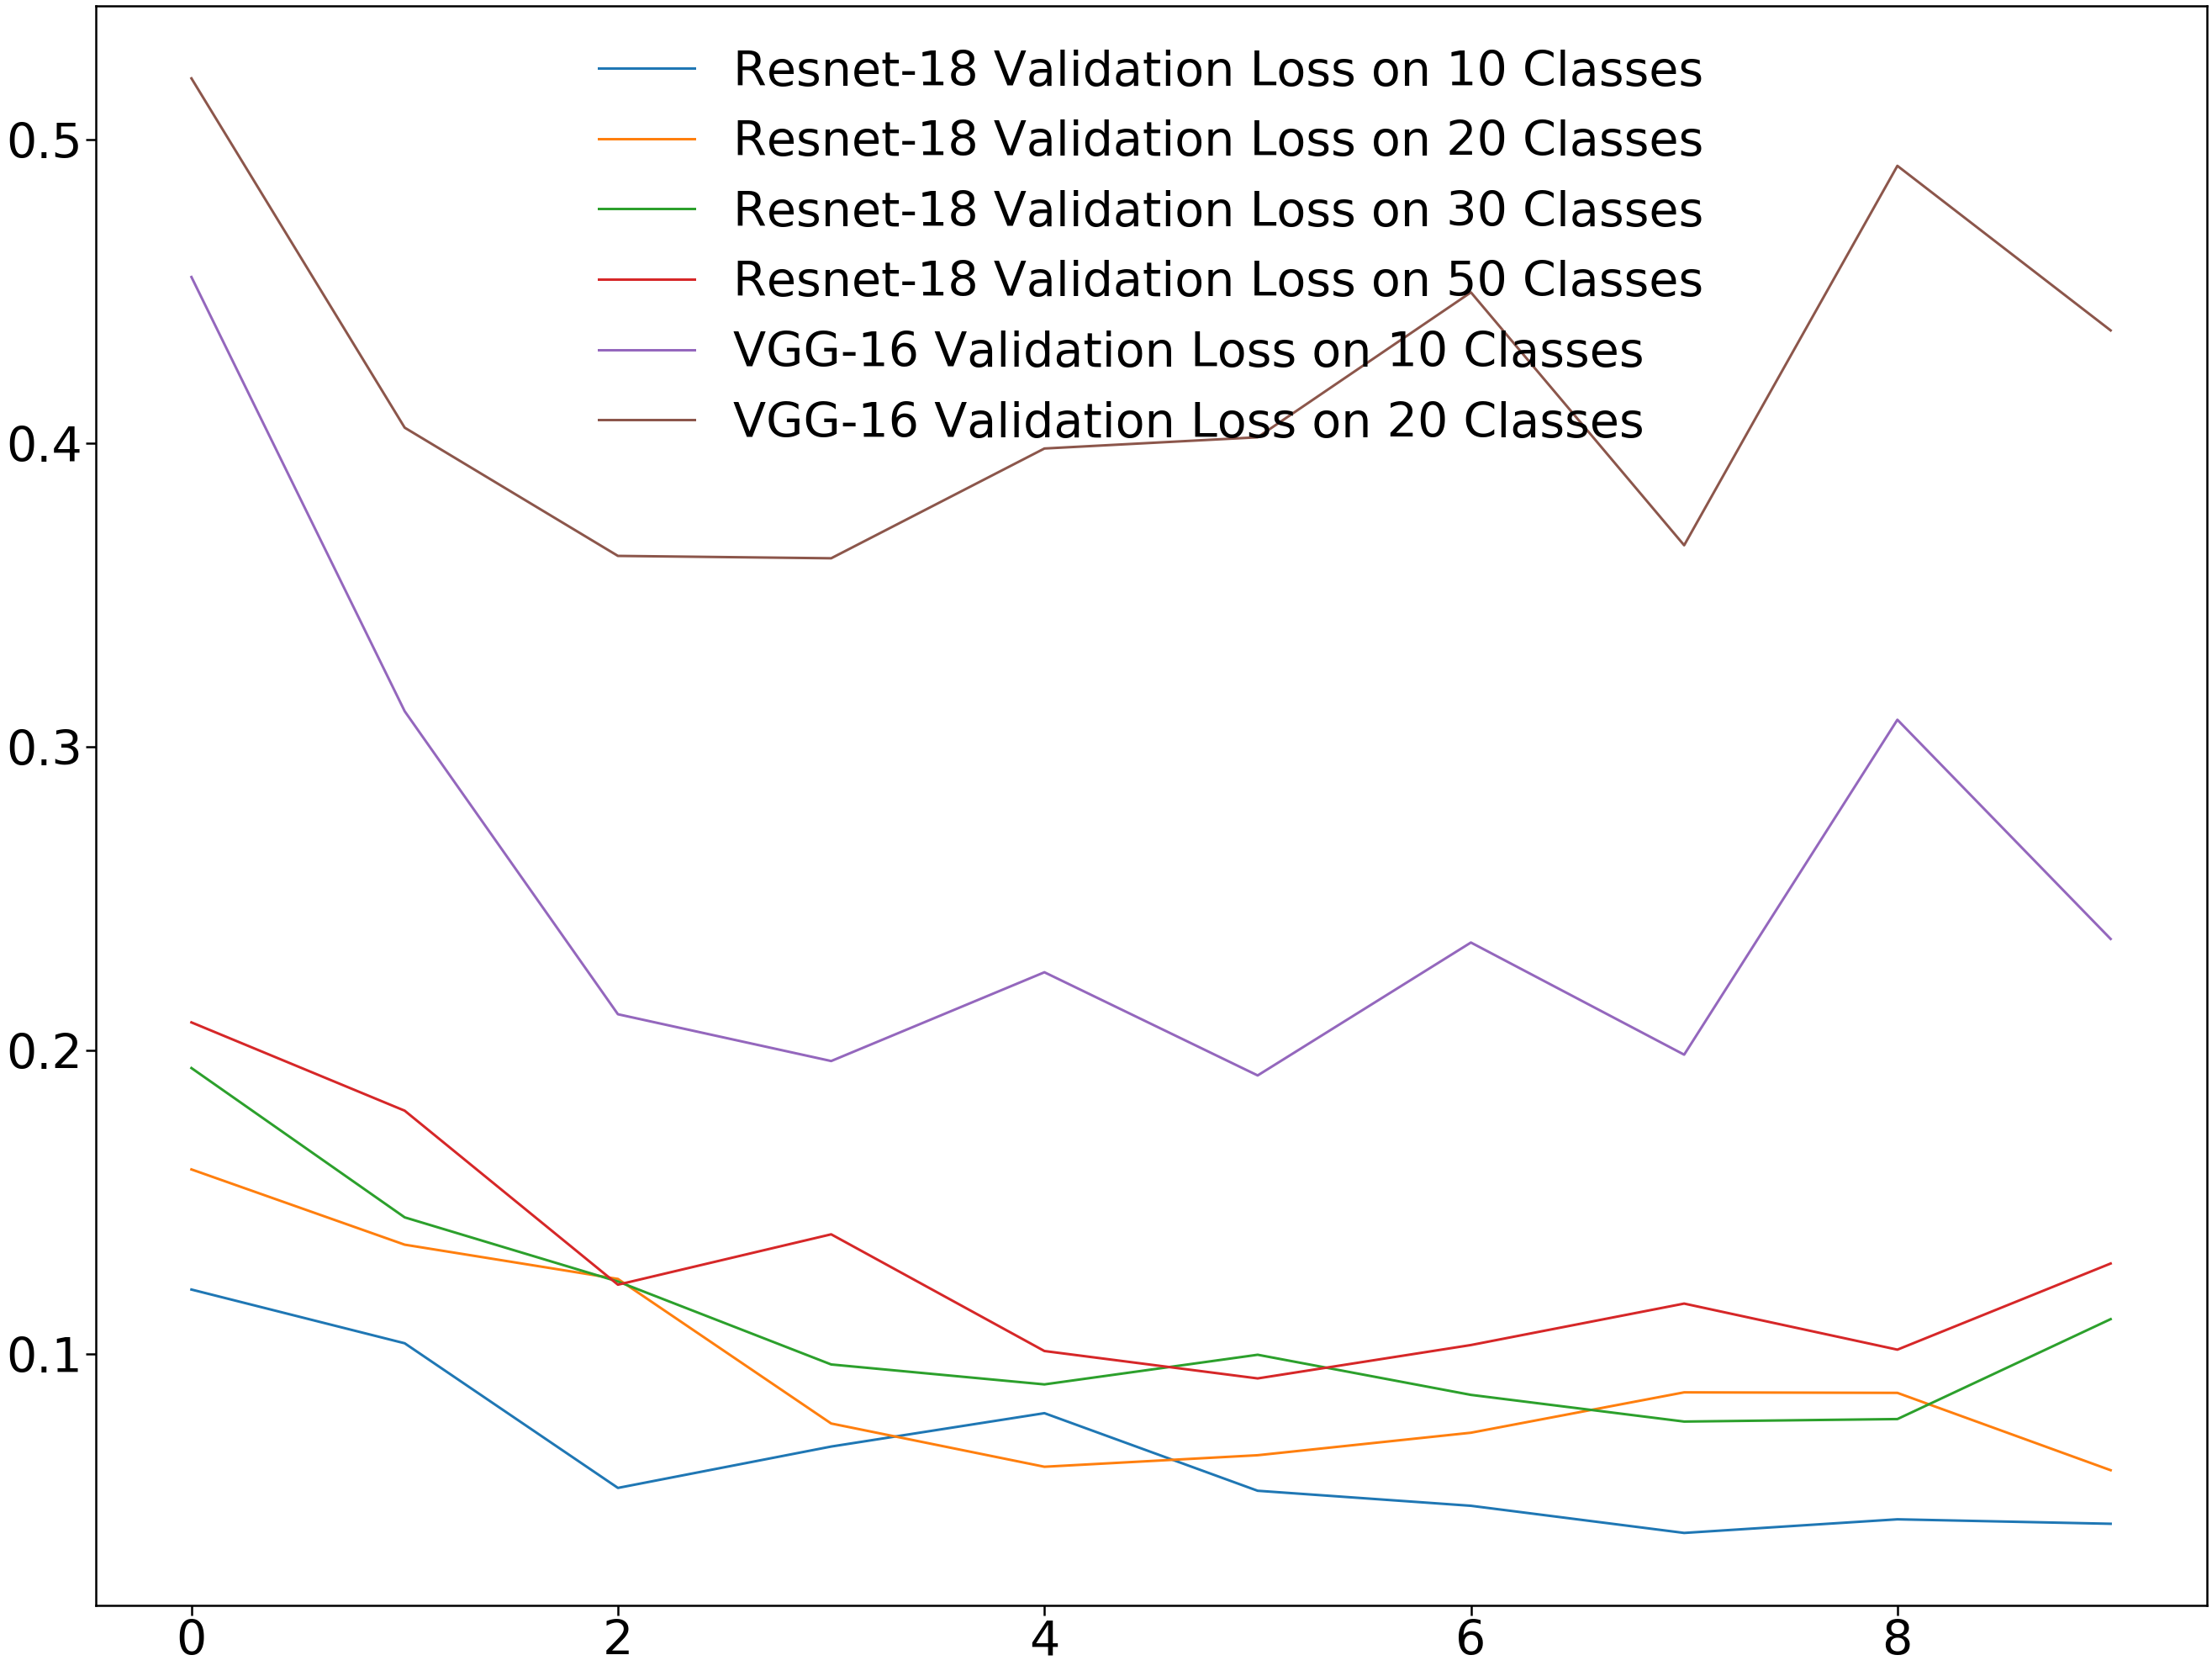

In [16]:
# plt.plot(resnet_10_results["train_accuracies"], label = "Resnet-18 Train Accuracy on 10 Classes")
# plt.plot(resnet_20_results["train_accuracies"], label = "Resnet-18 Train Accuracy on 20 Classes")
# plt.plot(resnet_30_results["train_accuracies"], label = "Resnet-18 Train Accuracy on 30 Classes")

# plt.plot(vgg_10_results["train_accuracies"], label = "VGG-16 Train Accuracy on 10 Classes")
# plt.plot(vgg_20_results["train_accuracies"], label = "VGG-16 Train Accuracy on 20 Classes")

plt.figure(figsize = (45, 35))
plt.plot(resnet_10_results["valid_losses"], label = "Resnet-18 Validation Loss on 10 Classes")
plt.plot(resnet_20_results["valid_losses"], label = "Resnet-18 Validation Loss on 20 Classes")
plt.plot(resnet_30_results["valid_losses"], label = "Resnet-18 Validation Loss on 30 Classes")
plt.plot(resnet_50_results["valid_losses"], label = "Resnet-18 Validation Loss on 50 Classes")

plt.plot(vgg_10_results["valid_losses"], label = "VGG-16 Validation Loss on 10 Classes")
plt.plot(vgg_20_results["valid_losses"], label = "VGG-16 Validation Loss on 20 Classes")

plt.legend(frameon=False)
plt.savefig('validation_loss.png')
plt.show()

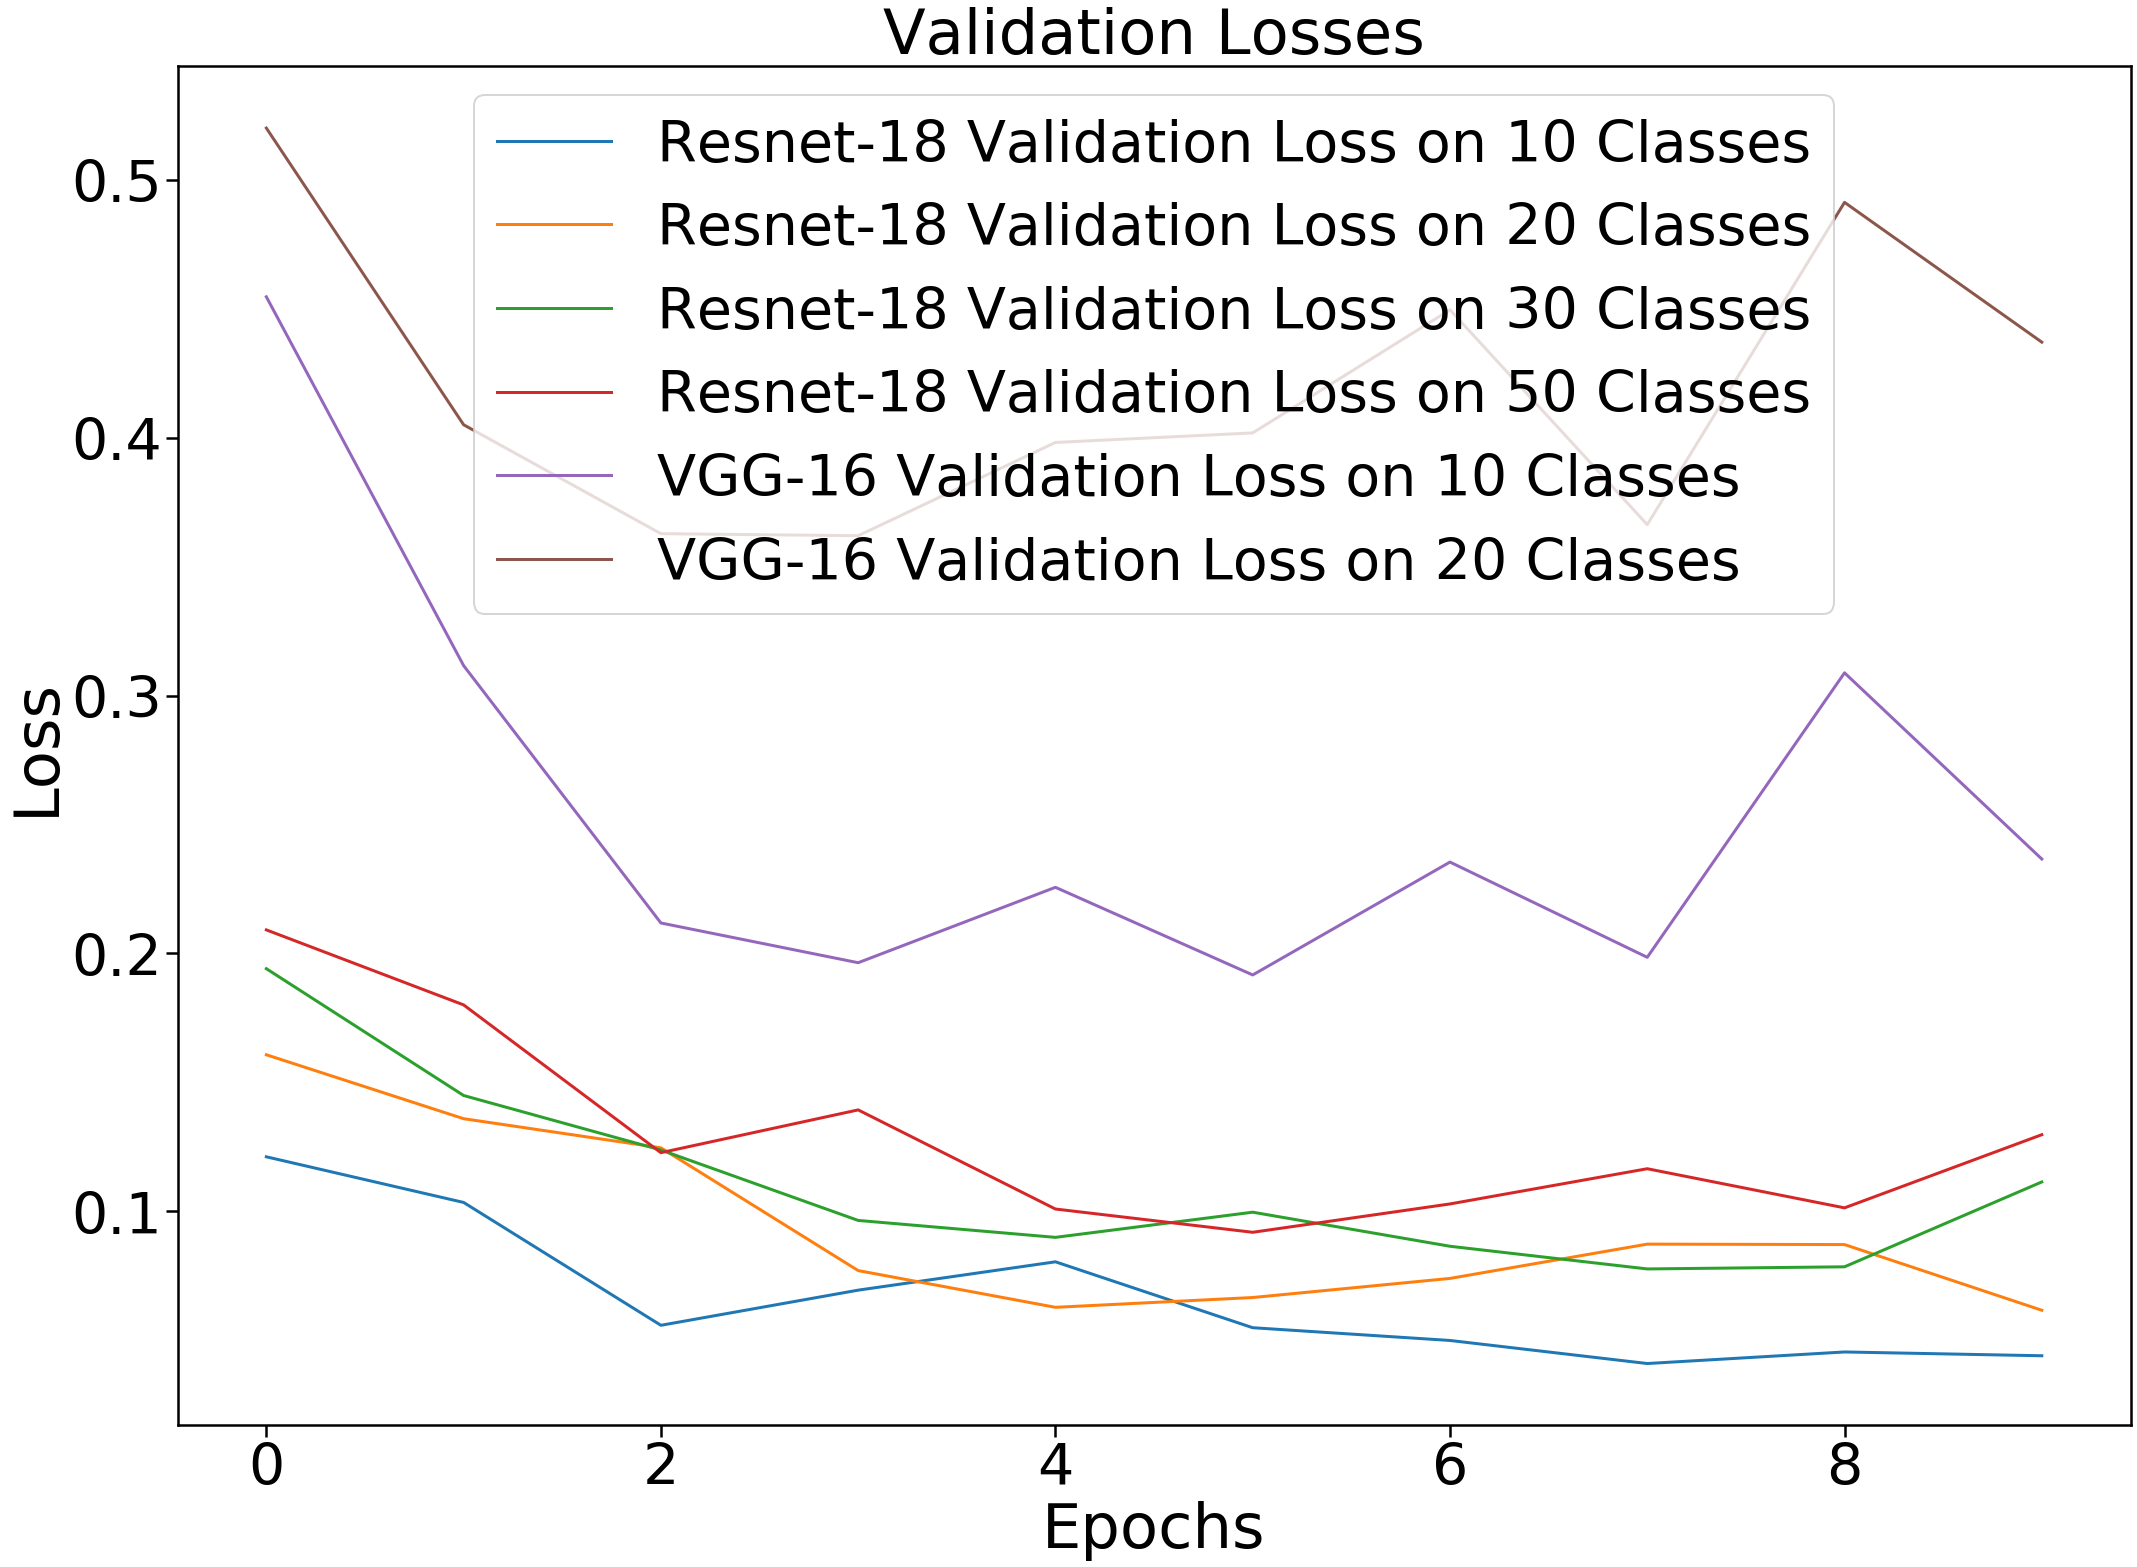

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize = (35, 25))

epochs = np.arange(10)
#sns.set_context("poster", font_scale = 1.6)
sns.lineplot(x = epochs, y = resnet_10_results["valid_losses"], label="Resnet-18 Validation Loss on 10 Classes")
sns.lineplot(x = epochs, y = resnet_20_results["valid_losses"], label="Resnet-18 Validation Loss on 20 Classes")
sns.lineplot(x = epochs, y = resnet_30_results["valid_losses"], label="Resnet-18 Validation Loss on 30 Classes")
sns.lineplot(x = epochs, y = resnet_50_results["valid_losses"], label="Resnet-18 Validation Loss on 50 Classes")

sns.lineplot(x = epochs, y = vgg_10_results["valid_losses"], label="VGG-16 Validation Loss on 10 Classes")
sns.lineplot(x = epochs, y = vgg_20_results["valid_losses"], label="VGG-16 Validation Loss on 20 Classes")

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Validation Losses")
plt.legend(loc='upper center')
plt.savefig('validation_loss_seaborn.png')
plt.show()

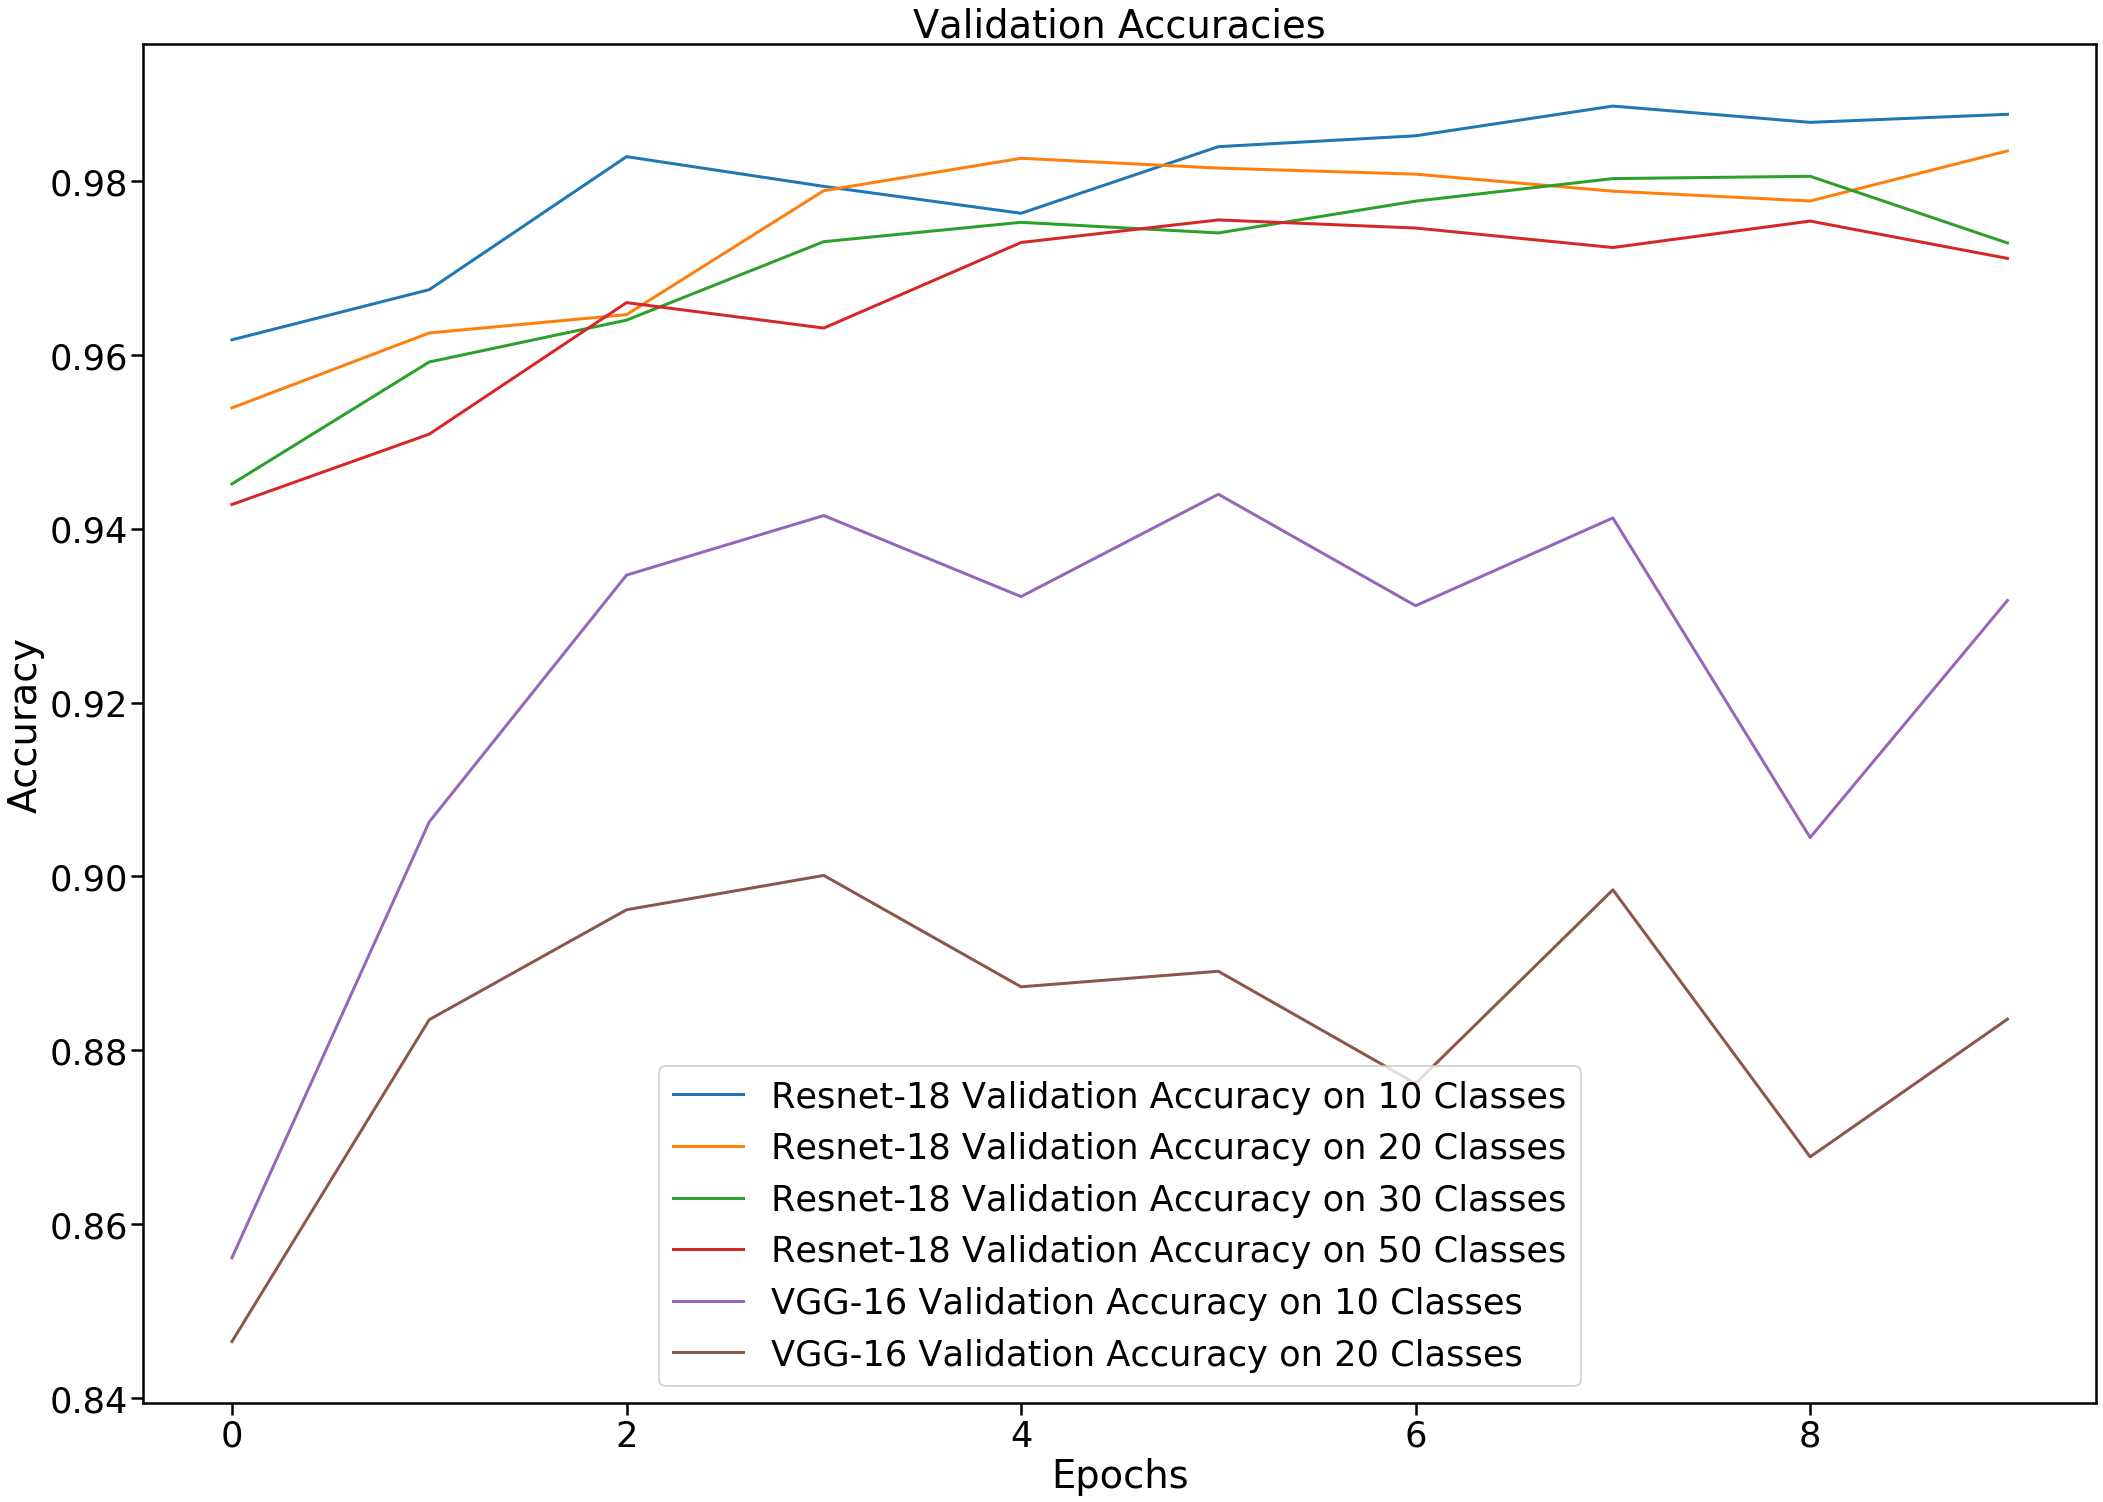

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize = (35, 25))

epochs = np.arange(10)
sns.set_context("poster", font_scale=1.6)
sns.lineplot(x = epochs, y = resnet_10_results["valid_accuracies"], label="Resnet-18 Validation Accuracy on 10 Classes")
sns.lineplot(x = epochs, y = resnet_20_results["valid_accuracies"], label="Resnet-18 Validation Accuracy on 20 Classes")
sns.lineplot(x = epochs, y = resnet_30_results["valid_accuracies"], label="Resnet-18 Validation Accuracy on 30 Classes")
sns.lineplot(x = epochs, y = resnet_50_results["valid_accuracies"], label="Resnet-18 Validation Accuracy on 50 Classes")

sns.lineplot(x = epochs, y = vgg_10_results["valid_accuracies"], label="VGG-16 Validation Accuracy on 10 Classes")
sns.lineplot(x = epochs, y = vgg_20_results["valid_accuracies"], label="VGG-16 Validation Accuracy on 20 Classes")

plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Validation Accuracies")
plt.savefig('validation_accuracy_seaborn.png')
plt.show()

In [19]:
def get_index_from_value(l, value):
    for i in range(len(l)):
        if value == l[i]:
            return i

def get_value_from_index(l, index):
    return l[index]

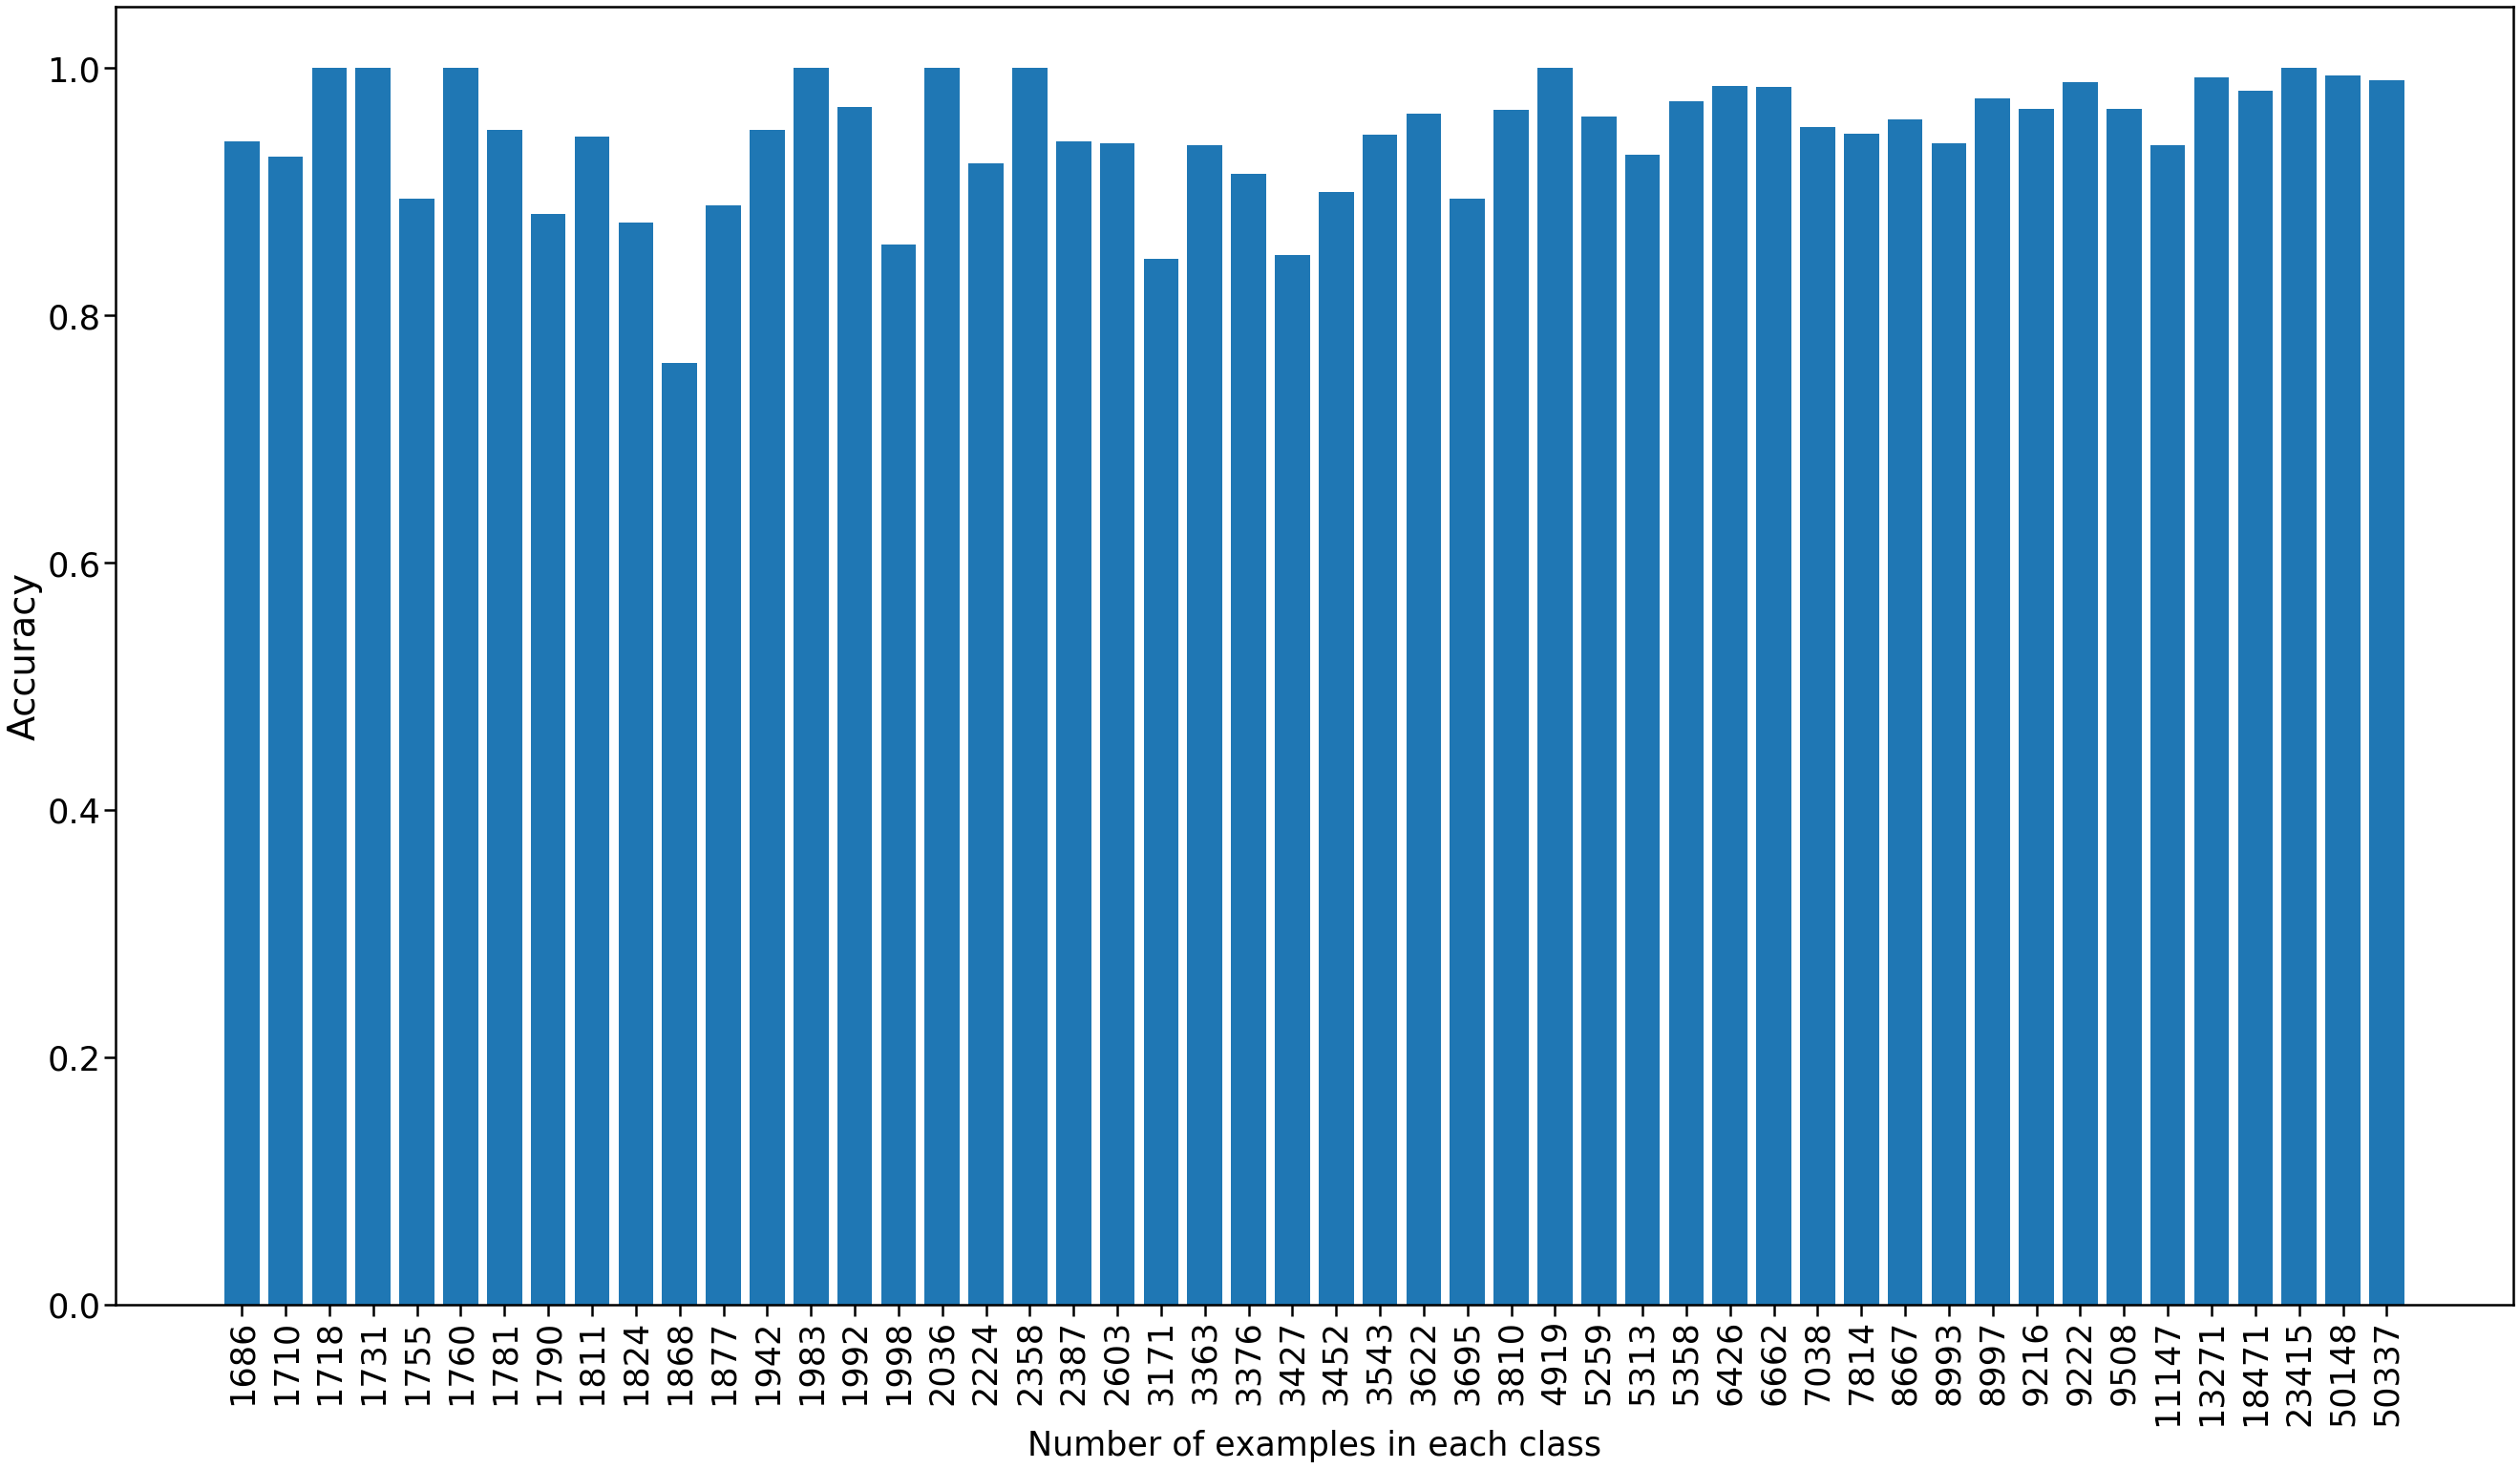

In [20]:
import collections

classes = np.arange(50)

plt.figure(figsize = (45, 25))
scores = [
0.84615385, 0.94666667, 0.94117647,  1.,         0.85714286, 0.99259259,
0.84848485, 0.92857143, 0.97560976, 0.875     , 1.        , 0.96875,
1.        , 0.89473684, 0.9375    , 0.93939394, 0.97297297, 1.,
0.96703297, 0.9375    , 1.        , 0.99404762, 1.        , 1.,
0.9673913 , 0.98850575, 0.94594595, 0.76190476, 0.88888889, 0.98484848,
0.89473684, 0.98550725, 0.93939394, 0.95      , 0.98989899, 0.98214286,
0.92307692, 1.        , 0.9       , 0.96296296, 0.95238095, 0.94117647,
0.94444444, 0.96078431, 0.91489362, 0.92982456, 0.96666667, 0.95,
0.95833333, 0.88235294 ]

most_frequent_50 = [
428, 1553, 1847, 1878, 2044, 2061, 
2338, 2449, 2743, 2870, 2949, 3283, 
3497, 3804, 3924, 4352, 4987, 5367, 
5376, 5554, 5955, 6051, 6231, 6599, 
6651, 6696, 7092, 7172, 7661, 8063, 
8169, 8429, 9029, 9434, 9633, 9779, 
10026, 10033, 10045, 10184, 10900, 
10932, 11249, 11784, 12172, 12220, 
12718, 13170, 13526, 13653]

unorder = most_frequent["landmark_id"].values
labels  = most_frequent["count"].values

dict_samples_scores = {}
for encoded_class in classes:
    #print(scores[encoded_class])
    #print(most_frequent["count"].loc[most_frequent['landmark_id'] == get_value_from_index(most_frequent_50, encoded_class)])
    
    key = most_frequent["count"].loc[most_frequent['landmark_id'] == get_value_from_index(most_frequent_50, encoded_class)].values[0]
    value = scores[encoded_class]
    
    dict_samples_scores.update( {key : value} )
    



order = collections.OrderedDict(sorted(dict_samples_scores.items()))


plt.bar(range(len(order)), list(order.values()))
plt.xticks(range(len(order)), list(order.keys()), rotation = "vertical", fontsize = 35)
plt.xlabel("Number of examples in each class", fontsize = 35)
plt.ylabel("Accuracy")
#plt.savefig('scores_50_plt.png')
plt.show()

# sns.countplot(x = unorder, y = scores, color = "indigo")
# plt.xticks(unorder, labels, rotation='vertical')
# sns.set_xticklabels(labels, rotation=45)
# plt.show()